# Import Packages

In [1346]:

import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from pyomo.environ import*
import math
import csv
from IPython.display import display

from pyproj import Transformer 
from itertools import combinations
from shapely.geometry import LineString

import matplotlib.lines as mlines

# Access Files

Creating Dataframe of particular country and particular links

In [1347]:
filename = 'IS.csv'
file_path = filename

country_df = pd.read_csv(file_path)

print(f"Shape of df is: {country_df.shape}")
#display(country_df)  




## Add scaling factor if needed to the x y positions for graphing and optimisation
# Infeasible when x y values are too large

scaling_factor = 0.0001

# Scale 'src_x' and 'src_y' columns
country_df['src_x'] = country_df['src_x'] * scaling_factor
country_df['src_y'] = country_df['src_y'] * scaling_factor

# Scale 'dst_x' and 'dst_y' columns
country_df['dst_x'] = country_df['dst_x'] * scaling_factor
country_df['dst_y'] = country_df['dst_y'] * scaling_factor

display(country_df)


Shape of df is: (39, 18)


,link_id,src_bus_id,dst_bus_id,voltage,circuits,dc,underground,under_construction,length_m,tags,src_coord,dst_coord,src_country,dst_country,src_x,src_y,dst_x,dst_y
0,9014,6093,6094,132.0,1,f,f,f,85606.056856,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-23.148193, 65.789264)","(-21.851807, 65.467386)",IS,IS,-257.684506,981.940649,-243.253203,973.257397
1,9015,6107,6127,132.0,1,f,f,f,8526.255555,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-22.554932, 63.980781)","(-22.5, 63.908396)",IS,IS,-251.080355,934.488540,-250.468854,932.654039
2,9008,6089,6126,132.0,1,f,f,f,84167.700312,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-18.182373, 65.68543)","(-16.896973, 65.703518)",IS,IS,-202.405250,979.127752,-188.096243,979.616949
3,9009,6124,6126,132.0,1,f,f,f,137912.853760,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-15.172119, 64.914228)","(-16.896973, 65.703518)",IS,IS,-168.895256,958.581497,-188.096243,979.616949
4,9013,6098,6124,132.0,1,f,f,f,26730.997512,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-14.688721, 65.030423)","(-15.172119, 64.914228)",IS,IS,-163.514094,961.638963,-168.895256,958.581497
5,9012,6102,6120,132.0,1,f,f,f,74921.825029,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-18.083496, 63.81644)","(-19.248047, 64.177679)",IS,IS,-201.304557,930.330349,-214.268279,939.502791
6,9033,6103,6116,132.0,1,f,f,f,40026.269114,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-21.719971, 64.086607)","(-21.049805, 64.081805)",IS,IS,-241.785611,937.179122,-234.325357,937.056812
7,9034,6127,6128,132.0,1,f,f,f,9487.765121,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-22.5, 63.908396)","(-22.302246, 63.903564)",IS,IS,-250.468854,932.654039,-248.267467,932.531747
8,9020,6103,6115,132.0,1,f,f,f,26071.470229,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-21.719971, 64.086607)","(-21.236572, 64.187249)",IS,IS,-241.785611,937.179122,-236.404438,939.747409
9,9032,6103,6114,132.0,1,f,f,f,10353.579975,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-21.719971, 64.086607)","(-21.708984, 64.177679)",IS,IS,-241.785611,937.179122,-241.663304,939.502791


## Functions
Calculate Forward Sector : Calculates the sector of an edge starting at the positive x axis going in counterclockwise direction. Sectors are split from 0 - 7.

![image.png](attachment:image.png)

# Function - NetworkX Implementation and Attributes

In [1348]:
def calculate_forward_sector(src_x, src_y, dst_x, dst_y):
    dx = dst_x - src_x
    dy = dst_y - src_y
    
    # Angle in radians
    angle_rad = math.atan2(dy, dx)
    
    # Convert to degreees
    angle_deg = math.degrees(angle_rad)
    
    # Angle is rounded to nearest multiple of 45
    # Sector value calculated, modulo 8 used 
    sector = round(angle_deg / 45) % 8
    
    return sector





def euclidean_distance(src_x, src_y, dst_x, dst_y):
    dx = dst_x - src_x
    dy = dst_y - src_y
    
    return math.sqrt((dx)**2 + (dy)**2)




def get_non_incident_edge_pairs(G):
    non_incident_edge_pairs = []
    
    # combinations - generates all possible pairs of edges from graph G without repeating the same pair
    # '2' indicates we're looking for combinationes of 2 edges
    for edge1, edge2 in combinations(G.edges(), 2):
        
        # edges are sets and the '&' checks that they have no common elements (ie nodes)
        if not set(edge1) & set(edge2):
            non_incident_edge_pairs.append((edge1, edge2))
    return non_incident_edge_pairs    


def midpoint(pos1, pos2):
    """Calculate the midpoint between two positions."""
    return ((pos1[0] + pos2[0]) / 2, (pos1[1] + pos2[1]) / 2)



def calculate_distance(midpoint1, midpoint2):
    return math.sqrt((midpoint2[0] - midpoint1[0]) ** 2 + (midpoint2[1] - midpoint1[1]) ** 2)




def get_non_incident_edge_distance(G):
    non_incident_edge_distances = {}
    non_incident_edge_pairs = get_non_incident_edge_pairs(G)

    for edge1, edge2 in non_incident_edge_pairs:
        # Get the positions for the source and target nodes of each edge
        src_pos1, tgt_pos1 = G.nodes[edge1[0]]['pos'], G.nodes[edge1[1]]['pos']
        src_pos2, tgt_pos2 = G.nodes[edge2[0]]['pos'], G.nodes[edge2[1]]['pos']
        
        # Calculate the midpoints for each edge
        midpoint1 = midpoint(src_pos1, tgt_pos1)
        midpoint2 = midpoint(src_pos2, tgt_pos2)

        # Calculate the distance between the midpoints of the two edges
        dist = calculate_distance(midpoint1, midpoint2)

        # Store the distance with the edge pair as the key
        non_incident_edge_distances[(edge1, edge2)] = dist

    return non_incident_edge_distances




def calculate_angle(src_x, src_y, dst_x, dst_y):
    dx = dst_x - src_x
    dy = dst_y - src_y
    angle_radians = math.atan2(dy, dx)
    angle_degrees = math.degrees(angle_radians)  # Convert the angle to degrees
    
    # Normalize the angle to be within 0 to 360 degrees
    angle_degrees = (angle_degrees + 360) % 360

    return angle_degrees







 
def get_filtered_neighbour_order(G):
    
    # Convert the directed graph to an undirected graph to consider all adjacent nodes as neighbours
    G_undirected = G.to_undirected()
    
    # Create Dictionary to story nodes neighbour orders
    neighbour_order = {}
    for node in G_undirected.nodes():
        
        # Check if the node has 2 or more neighbours
        if G_undirected.degree(node) >= 2:
        
            # Access the position of the current node
            src_pos = G_undirected.nodes[node]['pos']
            src_x, src_y = src_pos
            
            # Create list to store angle size of neighbours with src node
            angles_neighbours = []
            
            
            
            for neighbour in G_undirected.neighbors(node):
                # Access the position tuple of the neighbour node using the 'pos' attribute
                dst_pos = G_undirected.nodes[neighbour]['pos']
                dst_x, dst_y = dst_pos
                
                # Calculate the angle from the source node to the neighbour node
                angle = calculate_angle(src_x, src_y, dst_x, dst_y)
                
                # Append the angle and neighbour to the list
                angles_neighbours.append((angle, neighbour)) 
                
                
            
            # Sort the list of (angle, neighbour) pairs by angle in ascending order
            angles_neighbours.sort()
            
            # Extract the sorted neighbours from the sorted list of pairs
            sorted_neighbours = [neighbour for _, neighbour in angles_neighbours]
            
            # Check conditions to move the last neighbour to the first position
            if angles_neighbours[-1][0] > 315 and ((360 - angles_neighbours[-1][0]) < angles_neighbours[0][0]):
                # Move the last neighbour to the first position
                sorted_neighbours.insert(0, sorted_neighbours.pop())
            
            
            # Store the sorted list of neighbours in the dictionary with the src_node as the key
            neighbour_order[node] = sorted_neighbours
    
    return neighbour_order
   

# NetworkX Implementation
Dataframe is accessed where nodes and edges are added to graph. 
Forward and backward sector of a particular edge are found and stored as attributes along with the voltage information.

In [1349]:

# Initialize a directed graph since we have source and destination
G = nx.DiGraph()

# Loop through the DataFrame rows to add edges and nodes to the graph
for index, row in country_df.iterrows():
    src_node = row['src_bus_id']
    dst_node = row['dst_bus_id']
    voltage = row['voltage']
    
    # Add the source and destination nodes if they don't already exist
    if src_node not in G:
        G.add_node(src_node, pos=(row['src_x'], row['src_y']))
    if dst_node not in G:
        G.add_node(dst_node, pos=(row['dst_x'], row['dst_y']))
        
        
        
    # Calculate the forward sector for edges
    forward_sector = calculate_forward_sector(row['src_x'], row['src_y'], row['dst_x'], row['dst_y'])

    # Backward sector
    backward_sector = (forward_sector + 4) % 8
    
    distance = euclidean_distance(row['src_x'], row['src_y'], row['dst_x'], row['dst_y'])
    
    # Add an edge between the source and destination nodes, voltage is attribute
    G.add_edge(src_node, dst_node, 
               voltage = voltage, 
               forward_sector = forward_sector, 
               backward_sector = backward_sector,
               distance = distance
               )


# Create list of non-incident edge pairs
non_incident_edge_pairs = get_non_incident_edge_pairs(G)

print(non_incident_edge_pairs)



# Print non-incident edge pairs
print("Non-incident edge pairs:")
for edge_pair in non_incident_edge_pairs:
    print(edge_pair)
    
ordered_neighbours_dict = get_filtered_neighbour_order(G)
print("\nNodes with more than 2 neighbours ordered:")
print(ordered_neighbours_dict)
for node, neighbours in ordered_neighbours_dict.items():
    print(len(neighbours))
    
    
 # dictionary
non_incident_edge_distances = get_non_incident_edge_distance(G)

# Find the non-incident edge pair with the maximum distance
max_distance_pair = max(non_incident_edge_distances, key=non_incident_edge_distances.get)

# Print the non-incident edge pair with the maximum distance and its value
max_distance_value = non_incident_edge_distances[max_distance_pair]
print(f"Non-incident edge pair with maximum distance: {max_distance_pair} with distance {max_distance_value}")
 

[((6093, 6094), (6107, 6127)), ((6093, 6094), (6127, 6128)), ((6093, 6094), (6127, 6129)), ((6093, 6094), (6089, 6126)), ((6093, 6094), (6089, 6097)), ((6093, 6094), (6124, 6126)), ((6093, 6094), (6098, 6124)), ((6093, 6094), (6098, 6100)), ((6093, 6094), (6098, 6099)), ((6093, 6094), (6102, 6120)), ((6093, 6094), (6120, 6123)), ((6093, 6094), (6103, 6116)), ((6093, 6094), (6103, 6115)), ((6093, 6094), (6103, 6114)), ((6093, 6094), (6103, 6108)), ((6093, 6094), (6103, 6105)), ((6093, 6094), (6116, 6123)), ((6093, 6094), (6114, 6115)), ((6093, 6094), (6097, 6112)), ((6093, 6094), (6095, 6112)), ((6093, 6094), (6095, 6096)), ((6093, 6094), (6096, 6110)), ((6093, 6094), (6105, 6107)), ((6093, 6094), (6105, 6123)), ((6093, 6094), (6105, 6113)), ((6093, 6094), (6092, 6096)), ((6093, 6094), (6101, 6102)), ((6093, 6094), (6100, 6101)), ((6093, 6094), (6108, 6110)), ((6093, 6094), (6108, 6122)), ((6093, 6094), (6111, 6124)), ((6093, 6094), (6122, 6123)), ((6093, 6094), (6119, 6122)), ((6093, 6

## Drawing NetworkX Graph

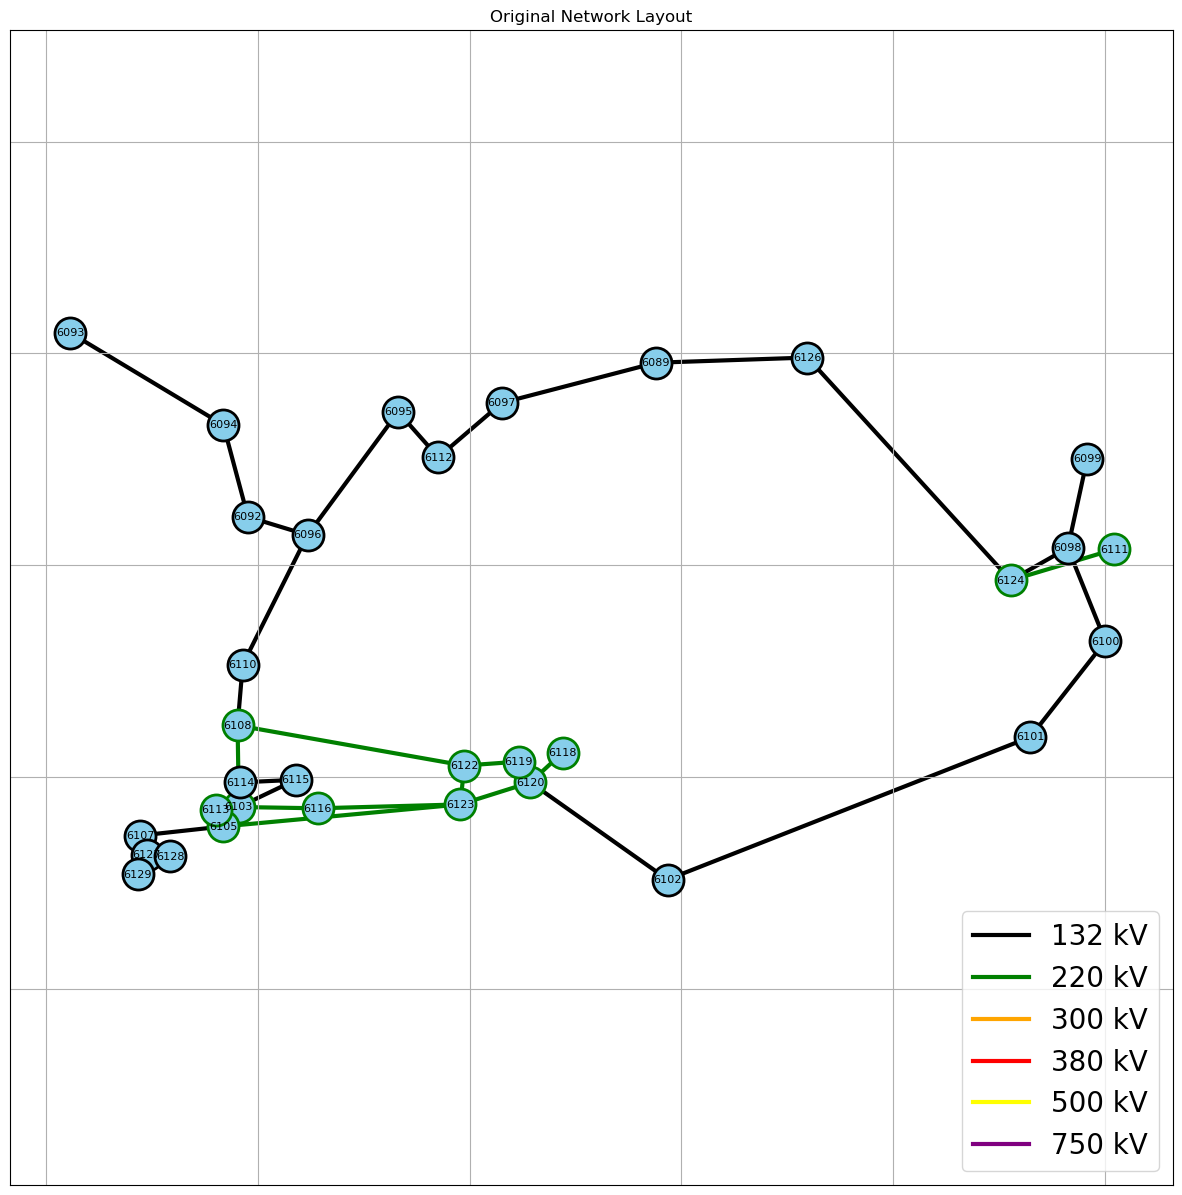

In [1350]:

pos = nx.get_node_attributes(G, 'pos')



""" def highest_voltage_color(G, node):
    # Get highest voltage of all connected edges
    highest_voltage = max((d['voltage'] for u, v, d in G.edges(node, data=True)), default=0)
    return voltage_colors.get(highest_voltage, 'grey')      #default colout """

""" 
def draw_graph(G, pos):
    plt.figure(figsize=(15, 15))
    
    # Convert to undirected graph for the purpose of finding node outline colors
    G_undirected = G.to_undirected()

    voltage_colors = {
        132: 'black',
        220: 'green',
        380: 'red',
        300: 'orange',
        500: 'yellow',
        750: 'purple'
    }

    # Determine the highest voltage color for each node
    node_outline_color = {}
    for node in G.nodes():
        connected_edges = G_undirected.edges(node, data=True)
        highest_voltage = max((data['voltage'] for _, _, data in connected_edges), default=0)
        node_outline_color[node] = voltage_colors.get(highest_voltage, 'grey')

    # Draw nodes with highest voltage outline color
    for node, color in node_outline_color.items():
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='skyblue',
                               edgecolors=color, node_size=500, linewidths=2)


    # Define custom lines for the legend with appropriate colors and labels for each voltage level
    legend_lines = [
        
        mlines.Line2D([], [], color='black', markersize=30, label='132 kV', linewidth=3),
        mlines.Line2D([], [], color='green', markersize=30, label='220 kV', linewidth=3),
        mlines.Line2D([], [], color='orange', markersize=30, label='300 kV', linewidth=3),
        mlines.Line2D([], [], color='red', markersize=30, label='380 kV', linewidth=3),
        mlines.Line2D([], [], color='yellow', markersize=30, label='500 kV', linewidth=3),
        mlines.Line2D([], [], color='purple', markersize=30, label='750 kV', linewidth=3)
    ]

    # Draw the graph edges with different colors based on the voltage
    for (u, v, d) in G.edges(data=True):
        if d['voltage'] == 380:
            edge_color = 'red'
        elif d['voltage'] == 220:
            edge_color = 'green'
        elif d['voltage'] == 132:
            edge_color = 'black'
        elif d['voltage'] == 300:
            edge_color = 'orange'
        elif d['voltage'] == 500:
            edge_color = 'yellow'
        elif d['voltage'] == 750:
            edge_color = 'purple'
        else:
            edge_color = 'grey'  # Default color for unspecified or unknown voltages
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=edge_color, width=3, arrows=False)

    # Draw the node labels
    nx.draw_networkx_labels(G, pos, font_size=8)

    # Create edge labels for voltages, using 'link_id' or another attribute if desired
    edge_labels = nx.get_edge_attributes(G, 'link_id')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_size=7)

    # Add the legend to the plot with all line types
    plt.legend(handles=legend_lines, loc='lower right', fontsize=20)
    plt.axis('equal')
    plt.grid(True)
    # Show the plot
    plt.show()
    
    
draw_graph(G, pos)
 """
 
 
 
 
def draw_graph(G, pos, ax=None, title="Network Layout"):
    if ax is None:
        # Creating a new figure if no axis is provided
        fig, ax = plt.subplots(figsize=(15, 15))
    
    ax.set_title(title)
    
    # Convert to undirected graph for the purpose of finding node outline colors
    G_undirected = G.to_undirected()

    voltage_colors = {
        132: 'black',
        220: 'green',
        380: 'red',
        300: 'orange',
        500: 'yellow',
        750: 'purple'
    }

    # Determine the highest voltage color for each node
    node_outline_color = {}
    for node in G.nodes():
        connected_edges = G_undirected.edges(node, data=True)
        highest_voltage = max((data['voltage'] for _, _, data in connected_edges), default=0)
        node_outline_color[node] = voltage_colors.get(highest_voltage, 'grey')

    # Draw nodes with highest voltage outline color
    for node, color in node_outline_color.items():
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='skyblue',
                               edgecolors=color, node_size=500, linewidths=2, ax=ax)

    # Draw the graph edges with different colors based on the voltage
    for (u, v, d) in G.edges(data=True):
        if d['voltage'] == 380:
            edge_color = 'red'
        elif d['voltage'] == 220:
            edge_color = 'green'
        elif d['voltage'] == 132:
            edge_color = 'black'
        elif d['voltage'] == 300:
            edge_color = 'orange'
        elif d['voltage'] == 500:
            edge_color = 'yellow'
        elif d['voltage'] == 750:
            edge_color = 'purple'
        else:
            edge_color = 'grey'  # Default color for unspecified or unknown voltages
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=edge_color, width=3, arrows=False, ax=ax)

    # Draw the node labels
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    # Create edge labels for voltages, using 'link_id' or another attribute if desired
    edge_labels = nx.get_edge_attributes(G, 'link_id')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_size=7, ax=ax)

    # Define custom lines for the legend with appropriate colors and labels for each voltage level
    legend_lines = [
        mlines.Line2D([], [], color='black', markersize=30, label='132 kV', linewidth=3),
        mlines.Line2D([], [], color='green', markersize=30, label='220 kV', linewidth=3),
        mlines.Line2D([], [], color='orange', markersize=30, label='300 kV', linewidth=3),
        mlines.Line2D([], [], color='red', markersize=30, label='380 kV', linewidth=3),
        mlines.Line2D([], [], color='yellow', markersize=30, label='500 kV', linewidth=3),
        mlines.Line2D([], [], color='purple', markersize=30, label='750 kV', linewidth=3)
    ]

    # Add the legend to the plot with all line types
    ax.legend(handles=legend_lines, loc='lower right', fontsize=20)
    ax.axis('equal')
    ax.grid(True)

    # Show the plot if ax was not provided
    if ax is None:
        plt.show()
        
draw_graph(G, pos, title="Original Network Layout")

## Access edge information from NetworkX Graph

In [1351]:
def get_edge_info(G, edge):
    node1, node2 = edge
    
    # edge attributes eg voltage forward/backward sector are stored in edge data
    edge_data = G.get_edge_data(node1, node2)
    
    # Additional edge information
    edge_information = {
        'edge': edge,
        'source': node1,
        'destination': node2,
        'source_position': G.nodes[node1].get('pos'),
        'destination_position': G.nodes[node2].get('pos'),
        'source_neighbors': list(G.successors(node1)),  # or list(G.successors(u)) for DiGraph
        'destination_neighbors': list(G.predecessors(node2)),  # or list(G.predecessors(v)) for DiGraph
        'source_degree': G.degree(node1),
        'destination_degree': G.degree(node2)
    }
    
    # Merge edge_data into edge_info
    edge_information.update(edge_data)
    return edge_information

    
    
# Print Specified Edge Details
edge_details = {}
for edge in G.edges():
    edge_details[edge] = get_edge_info(G, edge)
    print(edge_details[edge])
    
    forward = edge_details[edge].get('forward_sector')
    backward = edge_details[edge].get('backward_sector')
    print(f"Forward sector for edge {edge}: {forward}")
    print(f"Backward sector for edge {edge}: {backward}\n") 
    


{'edge': (6093, 6094), 'source': 6093, 'destination': 6094, 'source_position': (-257.68450575444194, 981.9406494284744), 'destination_position': (-243.25320281528911, 973.2573974479512), 'source_neighbors': [6094], 'destination_neighbors': [6093, 6092], 'source_degree': 1, 'destination_degree': 2, 'voltage': 132.0, 'forward_sector': 7, 'backward_sector': 3, 'distance': 16.842249537364697}
Forward sector for edge (6093, 6094): 7
Backward sector for edge (6093, 6094): 3

{'edge': (6107, 6127), 'source': 6107, 'destination': 6127, 'source_position': (-251.0803545116912, 934.4885399641641), 'destination_position': (-250.46885428486556, 932.6540387552076), 'source_neighbors': [6127], 'destination_neighbors': [6107], 'source_degree': 2, 'destination_degree': 3, 'voltage': 132.0, 'forward_sector': 6, 'backward_sector': 2, 'distance': 1.9337340078384444}
Forward sector for edge (6107, 6127): 6
Backward sector for edge (6107, 6127): 2

{'edge': (6127, 6128), 'source': 6127, 'destination': 6128,

In [1352]:
# Debugging to check the sectors around the node 6188

# Usage example
edge_details = {}
for edge in G.edges():
    # Check if the node 6188 is part of the edge
    if 6188 in edge:
        edge_details[edge] = get_edge_info(G, edge)
        print(edge_details[edge])
        
        forward = edge_details[edge].get('forward_sector')
        backward = edge_details[edge].get('backward_sector')
        print(f"Forward sector for edge {edge}: {forward}")
        print(f"Backward sector for edge {edge}: {backward}\n") 


Create Dictionary of initial lengths of each edge

In [1353]:
initial_lengths = {}

for edge in G.edges():
    edge_info = get_edge_info(G, edge)  # Retrieve edge information

    # Assuming the 'get_edge_info' function returns a dictionary with the positions
    node1_pos = edge_info.get('source_position')  # Source position (x, y)
    node2_pos = edge_info.get('destination_position')  # Destination position (x, y)

    # Calculate the Euclidean distance between node1 and node2
    distance = euclidean_distance(node1_pos[0], node1_pos[1], node2_pos[0], node2_pos[1])

    # Store the distance in the initial_lengths dictionary using the edge as the key
    initial_lengths[edge] = distance

print(initial_lengths)    

# Calculate min, max, and average lengths
min_length = min(initial_lengths.values())
max_length = max(initial_lengths.values())
avg_length = sum(initial_lengths.values()) / len(initial_lengths)

print("\nMinimum Length:", min_length)
print("\nMaximum Length:", max_length)
print("\nAverage Length:", avg_length)

{(6093, 6094): 16.842249537364697, (6107, 6127): 1.9337340078384444, (6127, 6128): 2.204781638689382, (6127, 6129): 2.024417626257664, (6089, 6126): 14.317367258665438, (6089, 6097): 15.039324372348803, (6124, 6126): 28.48101350430561, (6098, 6124): 6.189103295366581, (6098, 6100): 9.492968540453184, (6098, 6099): 8.635755360401173, (6102, 6120): 15.880547299139495, (6120, 6123): 6.9236958273604, (6103, 6116): 7.461256350965383, (6103, 6115): 5.9626437445867015, (6103, 6114): 2.326885391384382, (6103, 6108): 7.705817105889535, (6103, 6105): 2.349300484379718, (6116, 6123): 13.457917994994771, (6114, 6115): 5.264552499347192, (6097, 6112): 7.892799423554583, (6095, 6112): 5.718064958612575, (6095, 6096): 14.43184257131995, (6096, 6110): 13.673462715081634, (6105, 6107): 7.873828893763931, (6105, 6123): 22.477122961774302, (6105, 6113): 1.751067813689597, (6092, 6094): 8.988787964295602, (6092, 6096): 5.880548142318718, (6101, 6102): 36.79155437969402, (6100, 6101): 11.498732426715142, (

In [1354]:
"""## Calculate Baseline Minimum Edge Length
# - determines baseline min edge length based on distance of initial lengths
# percentile value, user determines

def calculate_baseline_edge_length(initial_lengths, percentile):
    return np.percentile(list(initial_lengths.values()), percentile)




## Calculate Local Density for each node
# calculates density of nodes around each node within a given radius (density radius)

def calculate_local_density(G, pos, density_radius):
    density_dict = {}
    for current_node in G.nodes():
        # Find all nodes within the specified radius
        nearby_nodes = [other_node for other_node in G.nodes() if euclidean_distance(pos[current_node][0], pos[current_node][1], pos[other_node][0], pos[other_node][1]) < density_radius]
        # Calculate density as the number of nodes per unit area (pi * radius^2)
        area = np.pi * density_radius ** 2
        density_dict[current_node] = len(nearby_nodes) / area
    return density_dict


## Calculate Average Node Density
def calculate_average_density(density_dict):
    return np.mean(list(density_dict.values()))

## Normalize scaling factor by network size
def normalize_by_network_size(G, base_scaling_factor):
    network_size = len(G.nodes())  # or len(G.edges()) if edge-based normalization is preferred
    normalized_factor = base_scaling_factor / network_size
    return normalized_factor


## Determine Scaling Factor
def determine_scaling_factor(G, density_dict):
    average_density = calculate_average_density(density_dict)
    base_scaling_factor = 1 / average_density  # Inverse of average density

    # Normalize by the number of nodes
    scaling_factor = normalize_by_network_size(G, base_scaling_factor)

    return scaling_factor




## Dynamic Min Edge Length
# calculates min length for each edge based on local density
# returns dictionary of min length with edges as keys

def calculate_dynamic_min_edge_length(G, density_dict, base_min_length):
    
    # Calculate scaling factor based on density and network size
    scaling_factor = determine_scaling_factor(G, density_dict)

    
    dynamic_min_lengths = {}
    for edge in G.edges():
        node1, node2 = edge
        local_density = max(density_dict[node1], density_dict[node2])
        dynamic_min_lengths[edge] = base_min_length / (1 + scaling_factor*local_density)
    return dynamic_min_lengths



## Set Density Radius
# - determines how local the 'local density' calculation is

base_min_length = calculate_baseline_edge_length(initial_lengths, 70)
print("Base min length: ", base_min_length)

# Density radius is 2.5 times the base min length
density_radius = round(base_min_length*1.5)

node_density_dict = calculate_local_density(G, pos, density_radius)

dynamic_min_edge_length_dict = calculate_dynamic_min_edge_length(G, node_density_dict, base_min_length)



print("\nBase min length: ", base_min_length)
print("\nDensity Radius: ", density_radius)
print("\nNode Density Dictionary: ", node_density_dict)
print("\nDynamic Min Edge Length Dictionary: ", dynamic_min_edge_length_dict)






def calculate_dynamic_min_spacing(dynamic_min_lengths, spacing_factor=0.5):
    dynamic_min_spacings = {edge: length * spacing_factor for edge, length in dynamic_min_lengths.items()}
    return dynamic_min_spacings

dynamic_min_spacings = calculate_dynamic_min_spacing(dynamic_min_edge_length_dict)

print("\nDynamic Min Edge Spacing: ", dynamic_min_spacings)  
""" 
""" import numpy as np

# Your existing imports and euclidean_distance function should be here
def calculate_baseline_edge_length(initial_lengths, percentile):
    return np.percentile(list(initial_lengths.values()), percentile)

def calculate_cluster_density(G, pos, cluster_threshold):
    cluster_density_dict = {}
    total_nodes = G.number_of_nodes()
    for current_node in G.nodes():
        nearby_nodes_count = sum(1 for other_node in G.nodes() 
                                 if euclidean_distance(pos[current_node][0], pos[current_node][1], pos[other_node][0], pos[other_node][1]) < cluster_threshold 
                                 and current_node != other_node)
        cluster_density_dict[current_node] = nearby_nodes_count / (total_nodes - 1)
    return cluster_density_dict

def calculate_dynamic_min_edge_length_based_on_clusters(G, pos, base_min_length, cluster_threshold):
    cluster_density_dict = calculate_cluster_density(G, pos, cluster_threshold)
    dynamic_min_lengths = {}
    for edge in G.edges():
        node1, node2 = edge
        local_cluster_density = max(cluster_density_dict[node1], cluster_density_dict[node2])
        dynamic_min_lengths[edge] = base_min_length * (1 - local_cluster_density)
    return dynamic_min_lengths

def calculate_dynamic_min_spacing(dynamic_min_lengths, spacing_factor):
    dynamic_min_spacings = {edge: length * spacing_factor for edge, length in dynamic_min_lengths.items()}
    return dynamic_min_spacings

# Your existing functions should be here

# Set parameters
base_min_length = calculate_baseline_edge_length(initial_lengths, 50)
print("Base min length: ", base_min_length)

# Set cluster threshold to 1.5 times the base minimum edge length
cluster_threshold = base_min_length * 1.5

# Calculate dynamic minimum edge lengths based on cluster density
dynamic_min_edge_length_dict = calculate_dynamic_min_edge_length_based_on_clusters(G, pos, base_min_length, cluster_threshold)

# Calculate dynamic minimum edge spacings based on dynamic edge lengths
dynamic_min_spacings = calculate_dynamic_min_spacing(dynamic_min_edge_length_dict, spacing_factor=1)

print("\nBase min length: ", base_min_length)
print("\nCluster Threshold: ", cluster_threshold)
print("\nDynamic Min Edge Length Dictionary: ", dynamic_min_edge_length_dict)
print("\nDynamic Min Edge Spacing: ", dynamic_min_spacings)
 """


' import numpy as np\n\n# Your existing imports and euclidean_distance function should be here\ndef calculate_baseline_edge_length(initial_lengths, percentile):\n    return np.percentile(list(initial_lengths.values()), percentile)\n\ndef calculate_cluster_density(G, pos, cluster_threshold):\n    cluster_density_dict = {}\n    total_nodes = G.number_of_nodes()\n    for current_node in G.nodes():\n        nearby_nodes_count = sum(1 for other_node in G.nodes() \n                                 if euclidean_distance(pos[current_node][0], pos[current_node][1], pos[other_node][0], pos[other_node][1]) < cluster_threshold \n                                 and current_node != other_node)\n        cluster_density_dict[current_node] = nearby_nodes_count / (total_nodes - 1)\n    return cluster_density_dict\n\ndef calculate_dynamic_min_edge_length_based_on_clusters(G, pos, base_min_length, cluster_threshold):\n    cluster_density_dict = calculate_cluster_density(G, pos, cluster_threshold)\n    dy

In [1355]:
def calculate_dynamic_min_lengths(G, avg_length, std_length):
    dynamic_min_lengths = {}
    
    # Get the maximum degree in the graph to normalize the local density
    max_degree = max(deg for node, deg in G.degree())

    # Iterate through each edge in the graph G
    for edge in G.edges():
        # Get the detailed information for the current edge
        edge_info = get_edge_info(G, edge)

        # Use the degree of nodes as a proxy for local density
        local_density = edge_info['source_degree'] + edge_info['destination_degree']
        
        # Scale the density factor non-linearly to increase variability
        # We subtract from 1 to ensure that higher density leads to shorter lengths
        density_factor = 1 - math.sqrt(local_density / (2 * max_degree))
        
        # Apply the adjustment based on local density and standard deviation
        adjusted_length = avg_length + std_length * density_factor
        
        # Ensure that the adjusted length is not below some minimum threshold if necessary
        min_threshold = avg_length * 0.5  # for example, at least 50% of the average length
        adjusted_length = max(adjusted_length, min_threshold)
        
        # Store the adjusted length
        dynamic_min_lengths[edge] = adjusted_length

    return dynamic_min_lengths

# Calculate the average and standard deviation of the initial edge lengths
lengths = [euclidean_distance(*G.nodes[edge[0]]['pos'], *G.nodes[edge[1]]['pos']) for edge in G.edges()]
avg_length = np.mean(lengths)
std_length = np.std(lengths)

# Use the function with the graph G
dynamic_min_edge_length_dict = calculate_dynamic_min_lengths(G, avg_length, std_length)
print(dynamic_min_edge_length_dict )








def calculate_dynamic_min_spacings(G):
    dynamic_min_spacings = {}
    spacings = []

    # Calculate initial spacings using the euclidean_distance function
    for edge in G.edges():
        edge_info = get_edge_info(G, edge)
        src_x, src_y = edge_info['source_position']
        dst_x, dst_y = edge_info['destination_position']
        spacing = euclidean_distance(src_x, src_y, dst_x, dst_y)
        spacings.append(spacing)
    
    # Calculate average and standard deviation of spacings
    avg_spacing = sum(spacings) / len(spacings)
    std_spacing = math.sqrt(sum((x - avg_spacing)**2 for x in spacings) / len(spacings))

    # Get the maximum degree in the graph to normalize the local density
    max_degree = max(deg for node, deg in G.degree())

    # Adjust spacings based on local density and incorporate std deviation
    for edge in G.edges():
        edge_info = get_edge_info(G, edge)
        local_density = edge_info['source_degree'] + edge_info['destination_degree']
        density_factor = 1 - math.sqrt(local_density / (2 * max_degree))
        
        # Use standard deviation to modulate the density factor dynamically
        adjusted_spacing = (avg_spacing + std_spacing * density_factor) * (1 - density_factor)
        min_threshold = avg_spacing * 0.5  # Ensure at least 30% of the average spacing
        adjusted_spacing = max(adjusted_spacing, min_threshold)
        
        dynamic_min_spacings[edge] = adjusted_spacing

    return dynamic_min_spacings

dynamic_min_spacings = calculate_dynamic_min_spacings(G)
print(dynamic_min_spacings)

""" min_edge_spacing = avg_length*0.2
print(min_edge_spacing) """

""" def calculate_dynamic_min_spacing(dynamic_min_lengths, spacing_factor):
    dynamic_min_spacings = {edge: length * spacing_factor for edge, length in dynamic_min_lengths.items()}
    return dynamic_min_spacings

dynamic_min_spacings = calculate_dynamic_min_spacing(dynamic_min_edge_length_dict, spacing_factor=0.2)
print(dynamic_min_spacings) """

{(6093, 6094): 13.279906954485295, (6107, 6127): 12.051926636739244, (6127, 6128): 12.62707932461215, (6127, 6129): 12.62707932461215, (6089, 6126): 12.62707932461215, (6089, 6097): 12.62707932461215, (6124, 6126): 12.051926636739244, (6098, 6124): 11.531948860619945, (6098, 6100): 12.051926636739244, (6098, 6099): 12.62707932461215, (6102, 6120): 11.531948860619945, (6120, 6123): 10.608711172561462, (6103, 6116): 11.053779946230417, (6103, 6115): 11.053779946230417, (6103, 6114): 11.053779946230417, (6103, 6108): 10.608711172561462, (6103, 6105): 10.190693441340803, (6116, 6123): 11.531948860619945, (6114, 6115): 12.62707932461215, (6097, 6112): 12.62707932461215, (6095, 6112): 12.62707932461215, (6095, 6096): 12.051926636739244, (6096, 6110): 12.051926636739244, (6105, 6107): 11.531948860619945, (6105, 6123): 10.608711172561462, (6105, 6113): 12.051926636739244, (6092, 6094): 12.62707932461215, (6092, 6096): 12.051926636739244, (6101, 6102): 12.62707932461215, (6100, 6101): 12.627079

' def calculate_dynamic_min_spacing(dynamic_min_lengths, spacing_factor):\n    dynamic_min_spacings = {edge: length * spacing_factor for edge, length in dynamic_min_lengths.items()}\n    return dynamic_min_spacings\n\ndynamic_min_spacings = calculate_dynamic_min_spacing(dynamic_min_edge_length_dict, spacing_factor=0.2)\nprint(dynamic_min_spacings) '

## Dynamic Min Length and Edge Spacing

In [1356]:
""" from scipy.stats import percentileofscore


G_undirected = G.to_undirected()


def calculate_baseline_edge_length(initial_lengths, percentile):
    return np.percentile(list(initial_lengths.values()), percentile)

def calculate_cluster_density(G):
    
    G_undirected = G.to_undirected()

    # Calculate density based on the number of connections
    cluster_density_dict = {}
    for node in G.nodes():
        neighbors_count = len(list(G_undirected.neighbors(node)))
        cluster_density_dict[node] = neighbors_count
    return cluster_density_dict

def calculate_percentile_based_edge_length(G, cluster_density_dict, base_min_length, percentile):
    # Using percentiles of connection counts to adjust lengths
    connection_counts = list(cluster_density_dict.values())
    dynamic_min_lengths = {}
    for edge in G.edges():
        node1, node2 = edge
        percentile1 = percentileofscore(connection_counts, cluster_density_dict[node1])
        percentile2 = percentileofscore(connection_counts, cluster_density_dict[node2])
        max_percentile = max(percentile1, percentile2)
        length_adjustment = (max_percentile / 100.0) * base_min_length
        dynamic_min_lengths[edge] = max(base_min_length - length_adjustment, base_min_length * 0.5)  # Ensure there is a minimum length
    return dynamic_min_lengths





def calculate_dynamic_min_spacing(dynamic_min_lengths, spacing_factor):
    dynamic_min_spacings = {edge: length * spacing_factor for edge, length in dynamic_min_lengths.items()}
    return dynamic_min_spacings



base_min_length = calculate_baseline_edge_length(initial_lengths, percentile=50)  # or another percentile as needed
print("Base min length:", base_min_length)

# Calculate the density based on the number of connections
node_density_dict = calculate_cluster_density(G)

# Calculate dynamic minimum edge lengths based on the density
dynamic_min_edge_length_dict = calculate_percentile_based_edge_length(G, node_density_dict, base_min_length, percentile=50)

# Calculate dynamic minimum edge spacings
dynamic_min_spacings = calculate_dynamic_min_spacing(dynamic_min_edge_length_dict, spacing_factor=0.3)

print("\nNode Density Dictionary:", node_density_dict)
print("\nDynamic Min Edge Length Dictionary:", dynamic_min_edge_length_dict)
print("\nDynamic Min Edge Spacing:", dynamic_min_spacings) """

' from scipy.stats import percentileofscore\n\n\nG_undirected = G.to_undirected()\n\n\ndef calculate_baseline_edge_length(initial_lengths, percentile):\n    return np.percentile(list(initial_lengths.values()), percentile)\n\ndef calculate_cluster_density(G):\n    \n    G_undirected = G.to_undirected()\n\n    # Calculate density based on the number of connections\n    cluster_density_dict = {}\n    for node in G.nodes():\n        neighbors_count = len(list(G_undirected.neighbors(node)))\n        cluster_density_dict[node] = neighbors_count\n    return cluster_density_dict\n\ndef calculate_percentile_based_edge_length(G, cluster_density_dict, base_min_length, percentile):\n    # Using percentiles of connection counts to adjust lengths\n    connection_counts = list(cluster_density_dict.values())\n    dynamic_min_lengths = {}\n    for edge in G.edges():\n        node1, node2 = edge\n        percentile1 = percentileofscore(connection_counts, cluster_density_dict[node1])\n        percentile2

## Details for networkX area - to get parameters for dmin

In [1357]:
# Extract the x and y coordinates separately
x_values = [position[0] for position in pos.values()]
y_values = [position[1] for position in pos.values()]

# Calculate the bounding box
min_x = min(x_values)
max_x = max(x_values)
min_y = min(y_values)
max_y = max(y_values)

# The bounding box is defined by the minimum and maximum x and y
bounding_box = (min_x, min_y, max_x, max_y)

print("Bounding box:", bounding_box)


# Calculate the area of the bounding box
area = (max_x - min_x) * (max_y - min_y)

# Determine the average area per node
average_area_per_node = area / len(pos)

# Estimate the minimum edge distance
minimum_edge_distance = average_area_per_node**0.5

print("Estimated minimum edge distance:", minimum_edge_distance)

# Assuming minimum_edge_distance is already calculated
factor = 0.2  # Starting with 10% of the edge length
minimum_edge_spacing = minimum_edge_distance * factor



Bounding box: (-257.68450575444194, 930.3303493244796, -159.1113192959798, 981.9406494284744)
Estimated minimum edge distance: 12.416254907138407


# Functions - Optimisation

### Octilinearity Constraints Functions
- Getting Dynamic Minimum Edge Length

In [1358]:
""" # to get dynamic min length 
# Minimum length percentage
def calculate_dynamic_min_lengths(G, min_length_horizontal, min_length_diagonal):
    # Dictionary to store dynamic minimum lengths for each edge
    dynamic_min_lengths = {}

    for edge in G.edges():
        edge_info = get_edge_info(G, edge)

        forward = edge_info.get('forward_sector')
        backward = edge_info.get('backward_sector')

        if forward in (1, 3, 5, 7) or backward in (1, 3, 5, 7):
            # Use the diagonal minimum length for diagonal edges
            #dynamic_min_length = edge_info['distance'] * min_length_diagonal
            dynamic_min_length = 1400
        else:
            # Use the horizontal minimum length for horizontal/vertical edges
            #dynamic_min_length = edge_info['distance'] * min_length_horizontal
            dynamic_min_length = 1400

        # Store the calculated dynamic minimum length in the dictionary
        dynamic_min_lengths[edge] = dynamic_min_length

    return dynamic_min_lengths
    
    
dynamic_min_lengths = calculate_dynamic_min_lengths(G, 0.2, 0.22)


print(dynamic_min_lengths)  """

" # to get dynamic min length \n# Minimum length percentage\ndef calculate_dynamic_min_lengths(G, min_length_horizontal, min_length_diagonal):\n    # Dictionary to store dynamic minimum lengths for each edge\n    dynamic_min_lengths = {}\n\n    for edge in G.edges():\n        edge_info = get_edge_info(G, edge)\n\n        forward = edge_info.get('forward_sector')\n        backward = edge_info.get('backward_sector')\n\n        if forward in (1, 3, 5, 7) or backward in (1, 3, 5, 7):\n            # Use the diagonal minimum length for diagonal edges\n            #dynamic_min_length = edge_info['distance'] * min_length_diagonal\n            dynamic_min_length = 1400\n        else:\n            # Use the horizontal minimum length for horizontal/vertical edges\n            #dynamic_min_length = edge_info['distance'] * min_length_horizontal\n            dynamic_min_length = 1400\n\n        # Store the calculated dynamic minimum length in the dictionary\n        dynamic_min_lengths[edge] = dynam

### Circular Vertex Order Constraints Functions

In [1359]:
## Function to get index of nodes in the ordered neighbours list.

# This function initializes the set of (node, index) pairs, where 'node' is a node with 2 or more neighbors,
# and 'index' is a unique integer (starting from 1) representing the position of a neighbor in the
# counterclockwise ordering of neighbors around 'node'.

def node_neighbour_index_pairs_init(model):
    node_index_pairs = []
    for node, neighbors in ordered_neighbours_dict.items():
        # Start index from 0 for each node's neighbors
        for idx in range(0, len(neighbors)):
            node_index_pairs.append((node, idx))
    return node_index_pairs



## Helper Function for the circular vertex order
## Determines if node with more than 2 neighbours is the source or destination node
## So the correct direction can be assigned to it

def directional_sector(model, node, neighbor):
    if (node, neighbor) in model.Edges:
        return model.dir_forward[node, neighbor]
    elif (neighbor, node) in model.Edges:
        return model.dir_backward[neighbor, node]
    else:
        return None  # This case should ideally never happen if the graph is well-defined

### Edge Spacing Constraints Functions
Gets list of intersecting edges and new list of non intersecting non incident edges created

In [1360]:


def list_edge_intersections(G):
    intersecting_edge_pairs = []
    non_incident_edge_pairs = get_non_incident_edge_pairs(G)

    for edge1, edge2 in non_incident_edge_pairs:
        # Get the positions for the source and target nodes of each edge
        src_pos1, tgt_pos1 = G.nodes[edge1[0]]['pos'], G.nodes[edge1[1]]['pos']
        src_pos2, tgt_pos2 = G.nodes[edge2[0]]['pos'], G.nodes[edge2[1]]['pos']
        
        # Create LineString objects for each edge
        line1 = LineString([src_pos1, tgt_pos1])
        line2 = LineString([src_pos2, tgt_pos2])

        # Check if the two edges intersect
        if line1.intersects(line2):
            # If they intersect, add the edge pair to the list
            intersecting_edge_pairs.append((edge1, edge2))

    return intersecting_edge_pairs

# Call the function to get intersecting edge pairs
intersecting_edges = list_edge_intersections(G)

# Print the intersecting edge pairs
for edge_pair in intersecting_edges:
    print(f"Intersecting Edge Pair: {edge_pair}")

Intersecting Edge Pair: ((6098, 6100), (6111, 6124))


In [1361]:
# Create a new list excluding intersecting edge pairs
non_intersecting_non_incident_edges = [edge_pair for edge_pair in non_incident_edge_pairs if edge_pair not in intersecting_edges]

# Print the new list of non-intersecting, non-incident edge pairs
for edge_pair in non_intersecting_non_incident_edges:
    print(f"Non-Intersecting Non-Incident Edge Pair: {edge_pair}")

Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6107, 6127))
Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6127, 6128))
Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6127, 6129))
Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6089, 6126))
Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6089, 6097))
Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6124, 6126))
Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6098, 6124))
Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6098, 6100))
Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6098, 6099))
Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6102, 6120))
Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6120, 6123))
Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6103, 6116))
Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6103, 6115))
Non-Intersecting Non-Incident Edge Pair: ((6093, 6094), (6103, 6114))
Non-Intersecting Non

# Optimisation

## Variables and Parameters

In [1362]:
model = ConcreteModel()



""" print(list(G.nodes()))
print(list(G.edges())) """
# Set used to index the other components eg Param and Var, and to define the scope
model.Nodes = Set(initialize = list(G.nodes()))
model.Edges = Set(initialize = list(G.edges()))

# Initialize set of non-incident edge pairs
# dimen = 4: creates a collection of edge pairs where each pair is treated as a single tuple, 2 integers per edge
model.NonIncidentEdges = Set(initialize = non_incident_edge_pairs, dimen=4)
model.NonIntersecting_NonIncidentEdges = Set(initialize = non_intersecting_non_incident_edges, dimen=4)
model.IntersectingEdgePairs = Set(initialize = intersecting_edges, dimen = 4)


# Set with 2 or more neighbours
# Storing set nodes with 2 or more neighbours that were predetermined in the dictionary
model.NodesWith2Neighbours = Set(initialize = ordered_neighbours_dict.keys())


# Initialize the set with the function that provides the (node, index) pairs
model.NodeNeighbours2IndexPairs = Set(dimen=2, initialize=node_neighbour_index_pairs_init)





### PARAM ###
## Param - fixed value in model that doesn't change during optimisation process ##
# pos defined earlier as tuple (x, y) in graph G
model.x_init = Param(model.Nodes, initialize={node: pos[node][0] for node in G.nodes()})
model.y_init = Param(model.Nodes, initialize={node: pos[node][1] for node in G.nodes()})


# Access information from dictionary of the edge info
edge_info = {edge: get_edge_info(G, edge) for edge in G.edges()}

# Initialize Params for static attributes from the edges
model.voltage = Param(model.Edges, initialize={edge: edge_info[edge]['voltage'] for edge in model.Edges})
model.sect_forward = Param(model.Edges, initialize={edge: edge_info[edge]['forward_sector'] for edge in model.Edges})
model.sect_backward = Param(model.Edges, initialize={edge: edge_info[edge]['backward_sector'] for edge in model.Edges})
model.distance = Param(model.Edges, initialize={edge: edge_info[edge]['distance'] for edge in model.Edges} )
#model.non_incident_edges = Param(model.Edges, initialize = {edge: edge_info[edge]['non_incident_edges'] for edge in model.Edges} )


# Param to store the ordered neighbors for each node in the model
model.OrderedNeighbours = Param(
    model.NodesWith2Neighbours,  # Index set for the Param, representing nodes with 2 or more neighbors
    within=Any,  # Specifies that the Param can hold any type of data, in this case, tuples of nodes
    initialize=lambda model, node: tuple(ordered_neighbours_dict[node])  # Initialization function
    # lambda function takes 2 arguments model and node (element from set Nodewith2Neigbours)
    # for each node, it gets the list or ordered neighbours from the dictionary
    # list is converted to tuple so that for Param, the contents are unchangeable
)
   
model.dynamicMinLengths = Param(model.Edges, within=NonNegativeReals, initialize=dynamic_min_edge_length_dict)
model.dynamicMinSpacings = Param(model.Edges, within=NonNegativeReals, initialize=dynamic_min_spacings)




### VARIABLES ###
## Define Variables ##
model.x_pos = Var(model.Nodes, within = Reals, initialize = model.x_init)
model.y_pos = Var(model.Nodes, within = Reals, initialize = model.y_init)

model.z1_pos = Expression(model.Nodes, rule = lambda model, node: model.x_pos[node] + model.y_pos[node])
model.z2_pos = Expression(model.Nodes, rule = lambda model, node: model.x_pos[node] - model.y_pos[node])


model.dir_forward = Var(model.Edges, within = Integers, bounds = (0, 7))
model.dir_backward = Var(model.Edges, within = Integers, bounds = (0, 7))


# Binary variable for octilinear constraint to determine where edge is drawn
model.alpha_pred = Var(model.Edges, within = Binary, bounds = (0, 1))
model.alpha_orig = Var(model.Edges, within = Binary, bounds = (0, 1))
model.alpha_succ = Var(model.Edges, within = Binary, bounds = (0, 1))


# Binary Variable for non-incident edge constraint
model.is_N = Var(model.NonIncidentEdges, within=Binary)
model.is_S = Var(model.NonIncidentEdges, within=Binary)
model.is_E = Var(model.NonIncidentEdges, within=Binary)
model.is_W = Var(model.NonIncidentEdges, within=Binary)
model.is_NE = Var(model.NonIncidentEdges, within=Binary)
model.is_NW = Var(model.NonIncidentEdges, within=Binary)
model.is_SE = Var(model.NonIncidentEdges, within=Binary)
model.is_SW = Var(model.NonIncidentEdges, within=Binary)

model.delta_pred = Var(model.Edges, within = Integers, bounds = (0, 7))
model.delta_orig = Var(model.Edges, within = Integers, bounds = (0, 7))
model.delta_succ = Var(model.Edges, within = Integers, bounds = (0, 7))


max_degree = max(len(neighbors) for neighbors in ordered_neighbours_dict.values())


# Define Beta as a binary variable indexed by the (node, index) pairs
# Beta[node, idx] will be used in the constraints to identify the "wrap-around" point
# in the counterclockwise ordering of neighbors around each node
model.Beta = Var(model.NodeNeighbours2IndexPairs, within=Binary)




# Redefine rpos as a continuous variable representing the deviation magnitude
model.rpos = Var(model.Edges, within=NonNegativeReals)


model.dev_pos = Var(model.Edges, within=NonNegativeReals)
model.dev_neg = Var(model.Edges, within=NonNegativeReals)

tolerance = 0.01






model.min_dist_x_pos = Var(model.IntersectingEdgePairs, within=NonNegativeReals)
model.min_dist_x_neg = Var(model.IntersectingEdgePairs, within=NonNegativeReals)
model.min_dist_y_pos = Var(model.IntersectingEdgePairs, within=NonNegativeReals)
model.min_dist_y_neg = Var(model.IntersectingEdgePairs, within=NonNegativeReals)










# Lower and upper bound factors
lower_bound_factor = 0.5  # e.g., 50% of the initial length
upper_bound_factor = 5  # e.g., 150% of the initial length

# Lower absolute threshold for very short edges
absolute_lower_threshold = 500  # Some unit length that makes sense for your graph's scale

# Define min_length as a variable for each edge
model.min_length = Var(model.Edges, within=NonNegativeReals, initialize=initial_lengths,
                       bounds=lambda model, u, v: (
                           max(absolute_lower_threshold, initial_lengths[u, v] * lower_bound_factor),
                           initial_lengths[u, v] * upper_bound_factor))





WARNING (W1002): Setting Var 'min_length[6093,6094]' to a numeric value
`16.842249537364697` outside the bounds (500, 84.21124768682348).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'min_length[6107,6127]' to a numeric value
`1.9337340078384444` outside the bounds (500, 9.668670039192222).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'min_length[6127,6128]' to a numeric value
`2.204781638689382` outside the bounds (500, 11.02390819344691).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'min_length[6127,6129]' to a numeric value
`2.024417626257664` outside the bounds (500, 10.12208813128832).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'min_length[6089,6126]' to a numeric value
`14.317367258665438` outside the bounds (500, 71.5868362933272).
    See also https://pyomo.readth

In [1363]:
""" # Define a ConstraintList for spacing constraints
model.EdgeSpacingConstraints = ConstraintList()

dmin = 50  # Minimum spacing distance, as an example

# Define the constraints
def enforce_minimum_spacing(model, u1, v1, u2, v2):
    # Constraints for node u2 to be at least dmin away from nodes u1 and v1
    model.EdgeSpacingConstraints.add(model.x_pos[u2] - model.x_pos[u1] >= dmin)
    model.EdgeSpacingConstraints.add(model.x_pos[u1] - model.x_pos[u2] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[u2] - model.y_pos[u1] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[u1] - model.y_pos[u2] >= dmin)

    model.EdgeSpacingConstraints.add(model.x_pos[u2] - model.x_pos[v1] >= dmin)
    model.EdgeSpacingConstraints.add(model.x_pos[v1] - model.x_pos[u2] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[u2] - model.y_pos[v1] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[v1] - model.y_pos[u2] >= dmin) 

    # Constraints for node v2 to be at least dmin away from nodes u1 and v1
    model.EdgeSpacingConstraints.add(model.x_pos[v2] - model.x_pos[u1] >= dmin)
    model.EdgeSpacingConstraints.add(model.x_pos[u1] - model.x_pos[v2] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[v2] - model.y_pos[u1] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[u1] - model.y_pos[v2] >= dmin)

    model.EdgeSpacingConstraints.add(model.x_pos[v2] - model.x_pos[v1] >= dmin)
    model.EdgeSpacingConstraints.add(model.x_pos[v1] - model.x_pos[v2] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[v2] - model.y_pos[v1] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[v1] - model.y_pos[v2] >= dmin) 

# Adding the constraints to the model for each pair of intersecting edges
for (u1, v1, u2, v2) in model.IntersectingEdgePairs:
    enforce_minimum_spacing(model, u1, v1, u2, v2)
 """


' # Define a ConstraintList for spacing constraints\nmodel.EdgeSpacingConstraints = ConstraintList()\n\ndmin = 50  # Minimum spacing distance, as an example\n\n# Define the constraints\ndef enforce_minimum_spacing(model, u1, v1, u2, v2):\n    # Constraints for node u2 to be at least dmin away from nodes u1 and v1\n    model.EdgeSpacingConstraints.add(model.x_pos[u2] - model.x_pos[u1] >= dmin)\n    model.EdgeSpacingConstraints.add(model.x_pos[u1] - model.x_pos[u2] >= dmin)\n    model.EdgeSpacingConstraints.add(model.y_pos[u2] - model.y_pos[u1] >= dmin)\n    model.EdgeSpacingConstraints.add(model.y_pos[u1] - model.y_pos[u2] >= dmin)\n\n    model.EdgeSpacingConstraints.add(model.x_pos[u2] - model.x_pos[v1] >= dmin)\n    model.EdgeSpacingConstraints.add(model.x_pos[v1] - model.x_pos[u2] >= dmin)\n    model.EdgeSpacingConstraints.add(model.y_pos[u2] - model.y_pos[v1] >= dmin)\n    model.EdgeSpacingConstraints.add(model.y_pos[v1] - model.y_pos[u2] >= dmin) \n\n    # Constraints for node v2 t

## Octilinearity Constraint

In [1364]:
# Sum of Binary variables is equal to 1
# node1 and node2 are the src and dst nodes defined in model.Edges
def alpha_direction_constraint(model, node1, node2):
    return model.alpha_pred[node1, node2] + model.alpha_orig[node1, node2] + model.alpha_succ[node1, node2] == 1
model.alpha_direction_constraint = Constraint(model.Edges, rule = alpha_direction_constraint)


 
 # for each edge in tuple (node1, node2) in model.Edges, dir constraint is called and formed
def dir_forward_constraint(model, node1, node2):
    
    
    sect_forward_pred = (model.sect_forward[node1, node2] - 1) % 8
    sect_forward_orig = model.sect_forward[node1, node2]
    sect_forward_succ = (model.sect_forward[node1, node2] + 1) % 8
    
     # Debugging: Print the values of sectors and binary variables
    """ print(f"Edge: {(node1, node2)}")
    print(f"sect_forward_pred: {sect_forward_pred}, sect_forward_orig: {sect_forward_orig}, sect_forward_succ: {sect_forward_succ}")
    print(f"alpha_pred[{node1}, {node2}]: {model.alpha_pred[node1, node2].value}")
    print(f"alpha_orig[{node1}, {node2}]: {model.alpha_orig[node1, node2].value}")
    print(f"alpha_succ[{node1}, {node2}]: {model.alpha_succ[node1, node2].value}") """
    
    
    
    return model.dir_forward[node1, node2] == ((sect_forward_pred * model.alpha_pred[node1, node2]) +
                                        (sect_forward_orig * model.alpha_orig[node1, node2]) +
                                        (sect_forward_succ * model.alpha_succ[node1, node2])
                                        )

model.DirForwardConstraint = Constraint(model.Edges, rule=dir_forward_constraint)
 

def dir_backward_constraint(model, node1, node2):
    sect_backward_pred = (model.sect_backward[node1, node2] - 1) % 8
    sect_backward_orig = model.sect_backward[node1, node2]
    sect_backward_succ = (model.sect_backward[node1, node2] + 1) % 8
    
      # Debugging: Print the values of sectors and binary variables
    """ print(f"Edge: {(node1, node2)}")
    print(f"sect_backward_pred: {sect_backward_pred}, sect_backward_orig: {sect_backward_orig}, sect_backward_succ: {sect_backward_succ}")
    print(f"alpha_pred[{node1}, {node2}]: {model.alpha_pred[node1, node2].value}")
    print(f"alpha_orig[{node1}, {node2}]: {model.alpha_orig[node1, node2].value}")
    print(f"alpha_succ[{node1}, {node2}]: {model.alpha_succ[node1, node2].value}")  """
    
    return model.dir_backward[node1, node2] == ((sect_backward_pred * model.alpha_pred[node1, node2]) +
                                        (sect_backward_orig * model.alpha_orig[node1, node2]) +
                                        (sect_backward_succ * model.alpha_succ[node1, node2])
                                        )
    
model.DirBackwardConstraint = Constraint(model.Edges, rule = dir_backward_constraint) 



tolerance_factor = 0.25
 
def sector_constraints_rule(model, node1, node2):

    # Retrieve original sector and minimum edge length
    sect_orig = model.sect_forward[node1, node2]
    #min_length = 1500 #dynamic_min_lengths[(node1, node2)] #(model.distance[node1, node2])*0.1  #1000
    #min_length = model.min_length[node1, node2]
    #min_length = minimum_edge_distance
    min_length = model.dynamicMinLengths[node1, node2] * (1 - tolerance_factor)  
    
    # Define a large constant M for making constraints trivial when not active
    M = 30000  # Adjust as needed

    # Iterate over each alpha variable and its corresponding sector adjustment
    for alpha, adjustment in zip([model.alpha_pred, model.alpha_orig, model.alpha_succ], [-1, 0, 1]):
        # Adjusted sector based on alpha variable
        sect_adjusted = (sect_orig + adjustment) % 8

        # Conditions based on adjusted sector
        if sect_adjusted in [0, 4]:  # Horizontal
            model.sector_constraints.add(model.y_pos[node1] - model.y_pos[node2] <= M * (1 - alpha[node1, node2]))
            model.sector_constraints.add(-model.y_pos[node1] + model.y_pos[node2] <= M * (1 - alpha[node1, node2]))
            
            if sect_adjusted == 0:
                # For sector 0, node1 should be to the left of node2 by at least min_length if this direction is selected
                model.sector_constraints.add(model.x_pos[node2] - model.x_pos[node1] >= min_length - M * (1 - alpha[node1, node2]))
                
                """ model.sector_constraints.add(model.dev_pos[node1, node2] >= model.y_pos[node2] - model.y_pos[node1] - tolerance)
                model.sector_constraints.add(model.dev_neg[node1, node2] >= -model.y_pos[node2] + model.y_pos[node1] - tolerance) """
                
                
                
                
                
            elif sect_adjusted == 4:
                # For sector 4, node1 should be to the right of node2 by at least min_length if this direction is selected
                model.sector_constraints.add(model.x_pos[node1] - model.x_pos[node2] >= min_length - M * (1 - alpha[node1, node2]))
                
                """ model.sector_constraints.add(model.dev_pos[node1, node2] >= model.y_pos[node2] - model.y_pos[node1] - tolerance)
                model.sector_constraints.add(model.dev_neg[node1, node2] >= -model.y_pos[node2] + model.y_pos[node1] - tolerance)
         """
        
        elif sect_adjusted in [2, 6]:  # Vertical
            # Add corresponding constraints for this sector
            model.sector_constraints.add(model.x_pos[node1] - model.x_pos[node2] <= M*(1 - alpha[node1, node2]))
            model.sector_constraints.add(-model.x_pos[node1] + model.x_pos[node2] <= M*(1 - alpha[node1, node2]))
            
            if sect_adjusted == 2:  # Upwards
                # Node2's y_pos should be at least min_length above Node1's y_pos
                model.sector_constraints.add(model.y_pos[node2] - model.y_pos[node1] >= min_length - M * (1 - alpha[node1, node2]))
                """ 
                model.sector_constraints.add(model.dev_pos[node1, node2] >= model.x_pos[node2] - model.x_pos[node1] - tolerance)
                model.sector_constraints.add(model.dev_neg[node1, node2] >= -model.x_pos[node2] + model.x_pos[node1] - tolerance)
                """
            
            
            
            
            elif sect_adjusted == 6:  # Downwards
                # Node2's y_pos should be at least min_length below Node1's y_pos
                model.sector_constraints.add(model.y_pos[node1] - model.y_pos[node2] >= min_length - M * (1 - alpha[node1, node2]))

                """ model.sector_constraints.add(model.dev_pos[node1, node2] >= model.x_pos[node2] - model.x_pos[node1] - tolerance)
                model.sector_constraints.add(model.dev_neg[node1, node2] >= -model.x_pos[node2] + model.x_pos[node1] - tolerance) """
        





        elif sect_adjusted == 1:         #upright diagonal /
            # dx = dy
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) <= M*(1 - alpha[node1, node2]))
            model.sector_constraints.add((model.y_pos[node2] - model.y_pos[node1]) - (model.x_pos[node2] - model.x_pos[node1]) <= M*(1 - alpha[node1, node2]))
            # dx + dy >= min length of diagonal
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M*(1 - alpha[node1, node2]))
            
            """ model.sector_constraints.add(model.dev_pos[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.sector_constraints.add(model.dev_neg[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance) """
        
            
        elif sect_adjusted == 5:        # Diagonal downwards /
            # dx = -dy
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) <= M*(1 - alpha[node1, node2]))
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) <= M*(1 - alpha[node1, node2]))
            # -dx - dy >= min length
            # negative diagonal
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M*(1 - alpha[node1, node2]))


            """ model.sector_constraints.add(model.dev_pos[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.sector_constraints.add(model.dev_neg[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance) """
        
            


            
        ## Diagonal \
            
        elif sect_adjusted == 3:    # Up left diagonal \
            # -dx = dy
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) <= M * (1 - alpha[node1, node2]))
            
            # Ensure dx is negative
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) <= 0)
            
            # -dx + dy >= min length (dx is negative value)
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M * (1 - alpha[node1, node2]))
            
            
            """ model.sector_constraints.add(model.dev_pos[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.sector_constraints.add(model.dev_neg[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
         """
            
            
        elif sect_adjusted == 7:    # Down right Diagonal \
            # dx = -dy
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) <= M * (1 - alpha[node1, node2]))
            
            # Ensure dy is negative
            model.sector_constraints.add((model.y_pos[node2] - model.y_pos[node1]) <= 0)
        
            # dx - dy >= min length (since dy is negative, we use -dy)
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M * (1 - alpha[node1, node2]))
            """ 
            model.sector_constraints.add(model.dev_pos[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.sector_constraints.add(model.dev_neg[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            """




       



       
            # Fill in your constraints similar to above
    return Constraint.Skip 

# Initialize the constraint list on your model if not already done
model.sector_constraints = ConstraintList()

# Apply the rule to each edge
model.SectorConstraint = Constraint(model.Edges, rule=sector_constraints_rule)

 
 

  

   


## Circular Vertex Order
The initial circular ordering of neighbour nodes (counterclockwise) should be the same after optimisation.

For each node in the map, the sequence in which the neighbouring nodes are arranged around a particular node should match the order in which the neighbouring nodes are arranged in the final layout.

In [1365]:
# Beta Binary Sum Constraint


def beta_sum_constraint_rule(model, node):
    # Ensure we use 0-based indexing to match the updated indexing in Beta
    # Note that RangeSet in Pyomo starts from 1, so we adjust the range accordingly
    return sum(model.Beta[node, index] for index in range(0, len(model.OrderedNeighbours[node]) )) == 1

model.BetaSumConstraint = Constraint(model.NodesWith2Neighbours, rule=beta_sum_constraint_rule)




# Define the ConstraintList in your Pyomo model
model.OrderMaintenanceConstraints = ConstraintList()


def add_order_maintenance_constraints(model):
    for node, neighbours in ordered_neighbours_dict.items():
        num_neighbours = len(neighbours)
        
        
        for index in range(num_neighbours):
            print(index)
            # Handle all neighbor pairs except the last pair (which wraps around)
            if index < num_neighbours - 1:
                next_index = index + 1
            else:
                next_index = 0      # wrap around case
                
                
            # Use the helper function to dynamically select dir_forward or dir_backward
            dir_sect = directional_sector(model, node, neighbours[index])
            next_dir_sect = directional_sector(model, node, neighbours[next_index])
            
            # Debugging prints before adding the constraint
            print(f"Node: {node}, Neighbour: {neighbours[index]}, Directional Sector: {dir_sect}")
            print(f"Node: {node}, Next Neighbour: {neighbours[next_index]}, Next Directional Sector: {next_dir_sect}")
            if index == num_neighbours - 1:  # For wrap-around case
                print(f"\nNode: {node}, Index: {index}, Beta: {model.Beta[node, index].value if model.Beta[node, index].value is not None else 'Not solved yet'}")

            
            
            if dir_sect is not None and next_dir_sect is not None:
                    model.OrderMaintenanceConstraints.add(dir_sect <= next_dir_sect - 1 + 8*model.Beta[node, index])

                

            
           
# Call the function to add the constraints to the ConstraintList
add_order_maintenance_constraints(model) 

0
Node: 6094, Neighbour: 6093, Directional Sector: dir_backward[6093,6094]
Node: 6094, Next Neighbour: 6092, Next Directional Sector: dir_backward[6092,6094]
1
Node: 6094, Neighbour: 6092, Directional Sector: dir_backward[6092,6094]
Node: 6094, Next Neighbour: 6093, Next Directional Sector: dir_backward[6093,6094]

Node: 6094, Index: 1, Beta: Not solved yet
0
Node: 6107, Neighbour: 6105, Directional Sector: dir_backward[6105,6107]
Node: 6107, Next Neighbour: 6127, Next Directional Sector: dir_forward[6107,6127]
1
Node: 6107, Neighbour: 6127, Directional Sector: dir_forward[6107,6127]
Node: 6107, Next Neighbour: 6105, Next Directional Sector: dir_backward[6105,6107]

Node: 6107, Index: 1, Beta: Not solved yet
0
Node: 6127, Neighbour: 6128, Directional Sector: dir_forward[6127,6128]
Node: 6127, Next Neighbour: 6107, Next Directional Sector: dir_backward[6107,6127]
1
Node: 6127, Neighbour: 6107, Directional Sector: dir_backward[6107,6127]
Node: 6127, Next Neighbour: 6129, Next Directional

## Edge Spacing 
Each edge must have a distance of at least dmin > 0 from each non incident edge.

- Prevents edge crossings
- maintains planarity (edges have minimum separation in at least 1 octilinear direction)
- enhances visualisation
- preserves topology structure

In [1366]:
def non_incident_edge_direction_constraint_rule(model, u1, v1, u2, v2):
    
    e1 = (u1, v1)
    e2 = (u2, v2)
        
    return (model.is_N[e1, e2] + model.is_S[e1, e2] + model.is_E[e1, e2] + model.is_W[e1, e2] +
            model.is_NE[e1, e2] + model.is_NW[e1, e2] + model.is_SE[e1, e2] + model.is_SW[e1, e2] >= 1)
    
model.NonIncidentEdgeDirectionConstraint = Constraint(model.NonIncidentEdges, rule=non_incident_edge_direction_constraint_rule)
#model.NonIncidentEdgeDirectionConstraint = Constraint(model.NonIntersecting_NonIncidentEdges, rule=non_incident_edge_direction_constraint_rule)





tolerance_factor = 0.25  # This defines a 10% tolerance, adjust as needed


# Initialize ConstraintList outside of function
# Adds new constraints to list in model without reinitializing it
model.edgeSpacingConstraints = ConstraintList()

def edge_spacing_constraint(model, u1, v1, u2, v2):
    
    
    e1 = (u1, v1)
    e2 = (u2, v2)
    
    
    #dmin = min_edge_spacing
    #dmin = model.dynamicMinSpacings[e1]    ## infeasibility coming from too small M value due to large distances between
    dmin = model.dynamicMinSpacings[e1] * (1 - tolerance_factor)

    M = 30000
    
    
    
    
    # is_N[e1, e2] means that e1 is north of e1
    
    ## North Constraint
    c1 = model.y_pos[u2] - model.y_pos[u1] <= M * (1 - model.is_N[e1, e2]) - dmin
    c2 = model.y_pos[v2] - model.y_pos[u1] <= M * (1 - model.is_N[e1, e2]) - dmin
    c3 = model.y_pos[u2] - model.y_pos[v1] <= M * (1 - model.is_N[e1, e2]) - dmin
    c4 = model.y_pos[v2] - model.y_pos[v1] <= M * (1 - model.is_N[e1, e2]) - dmin

    
    # South
    c5 = model.y_pos[u1] - model.y_pos[u2] <= M * (1 - model.is_S[e1, e2]) - dmin
    c6 = model.y_pos[v1] - model.y_pos[u2] <= M * (1 - model.is_S[e1, e2]) - dmin
    c7 = model.y_pos[u1] - model.y_pos[v2] <= M * (1 - model.is_S[e1, e2]) - dmin
    c8 = model.y_pos[v1] - model.y_pos[v2] <= M * (1 - model.is_S[e1, e2]) - dmin

    
    # is_E[e1, e2] = 1 means that e1 is East of e2
    ## East
    c9 = model.x_pos[u2] - model.x_pos[u1] <= M * (1 - model.is_E[e1, e2]) - dmin
    c10 = model.x_pos[v2] - model.x_pos[u1] <= M * (1 - model.is_E[e1, e2]) - dmin
    c11 = model.x_pos[u2] - model.x_pos[v1] <= M * (1 - model.is_E[e1, e2]) - dmin
    c12 = model.x_pos[v2] - model.x_pos[v1] <= M * (1 - model.is_E[e1, e2]) - dmin

    
    
    
    ## West
    c13 = model.x_pos[u1] - model.x_pos[u2] <= M * (1 - model.is_W[e1, e2]) - dmin
    c14 = model.x_pos[v1] - model.x_pos[u2] <= M * (1 - model.is_W[e1, e2]) - dmin
    c15 = model.x_pos[u1] - model.x_pos[v2] <= M * (1 - model.is_W[e1, e2]) - dmin
    c16 = model.x_pos[v1] - model.x_pos[v2] <= M * (1 - model.is_W[e1, e2]) - dmin

    
    
    ## NE
    c17 = model.z1_pos[u2] - model.z1_pos[u1] <= M * (1 - model.is_NE[e1, e2]) - dmin
    c18 = model.z1_pos[v2] - model.z1_pos[u1] <= M * (1 - model.is_NE[e1, e2]) - dmin
    c19 = model.z1_pos[u2] - model.z1_pos[v1] <= M * (1 - model.is_NE[e1, e2]) - dmin
    c20 = model.z1_pos[v2] - model.z1_pos[v1] <= M * (1 - model.is_NE[e1, e2]) - dmin

    
    
    ## NW
    c21 = model.z2_pos[u1] - model.z2_pos[u2] <= M * (1 - model.is_NW[e1, e2]) - dmin
    c22 = model.z2_pos[u1] - model.z2_pos[v2] <= M * (1 - model.is_NW[e1, e2]) - dmin
    c23 = model.z2_pos[v1] - model.z2_pos[u2] <= M * (1 - model.is_NW[e1, e2]) - dmin
    c24 = model.z2_pos[v1] - model.z2_pos[v2] <= M * (1 - model.is_NW[e1, e2]) - dmin

    
    
    # SE
    c25 = model.z2_pos[u2] - model.z2_pos[u1] <= M * (1 - model.is_SE[e1, e2]) - dmin
    c26 = model.z2_pos[v2] - model.z2_pos[u1] <= M * (1 - model.is_SE[e1, e2]) - dmin
    c27 = model.z2_pos[u2] - model.z2_pos[v1] <= M * (1 - model.is_SE[e1, e2]) - dmin
    c28 = model.z2_pos[v2] - model.z2_pos[v1] <= M * (1 - model.is_SE[e1, e2]) - dmin

    
    
    
    
    ## SW
    c29 = model.z1_pos[u1] - model.z1_pos[u2] <= M * (1 - model.is_SW[e1, e2]) - dmin
    c30 = model.z1_pos[u1] - model.z1_pos[v2] <= M * (1 - model.is_SW[e1, e2]) - dmin
    c31 = model.z1_pos[v1] - model.z1_pos[u2] <= M * (1 - model.is_SW[e1, e2]) - dmin
    c32 = model.z1_pos[v1] - model.z1_pos[v2] <= M * (1 - model.is_SW[e1, e2]) - dmin

    
    constraint_list = [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21, c22, c23, c24, c25, c26, c27, c28, c29, c30, c31, c32]

    # Add all constraints to the constraint list
    for constraint in constraint_list:
        model.edgeSpacingConstraints.add(constraint)
 
 
 

           
# Call edge_spacing_constraint for each non-incident edge pair
for u1, v1, u2, v2 in model.NonIntersecting_NonIncidentEdges :
    edge_spacing_constraint(model, u1, v1, u2, v2)
        
 


## Deviation Constraints



In [1367]:
model.dev_pos = Var(model.Edges, within=NonNegativeReals)
model.dev_neg = Var(model.Edges, within=NonNegativeReals)

tolerance = 0.01


model.DeviationConstraints = ConstraintList()


def dev_constraints_rule(model, node1, node2):
    
    sect_orig = model.sect_forward[node1, node2]
    
    # Iterate over each alpha variable and its corresponding sector adjustment
    for alpha, adjustment in zip([model.alpha_pred, model.alpha_orig, model.alpha_succ], [-1, 0, 1]):
        # Adjusted sector based on alpha variable
        sect_chosen = (sect_orig + adjustment) % 8
        
        
        if sect_chosen == 0:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= model.y_pos[node2] - model.y_pos[node1] - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= -model.y_pos[node2] + model.y_pos[node1] - tolerance)
            
            
        elif sect_chosen == 1:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            
        
        elif sect_chosen == 2:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= model.x_pos[node2] - model.x_pos[node1] - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= -model.x_pos[node2] + model.x_pos[node1] - tolerance)
                
                
        elif sect_chosen == 3:   
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            
            
        elif sect_chosen == 4:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= model.y_pos[node2] - model.y_pos[node1] - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= -model.y_pos[node2] + model.y_pos[node1] - tolerance)
            
            
        elif sect_chosen == 5:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            
            
        elif sect_chosen == 6:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= model.x_pos[node2] - model.x_pos[node1] - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= -model.x_pos[node2] + model.x_pos[node1] - tolerance)
            
            
        elif sect_chosen == 7:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            
        
    return Constraint.Skip



model.DevConstraint = Constraint(model.Edges, rule = dev_constraints_rule)
""" 
for edge in model.Edges:
    node1, node2 = edge
    dev_constraints_rule(model, node1, node2)  """ 

'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().


' \nfor edge in model.Edges:\n    node1, node2 = edge\n    dev_constraints_rule(model, node1, node2)  '

## Relative Position Constraint and Objective Function

In [1368]:

# Updated constraint without Big M
def rpos_constraint_upper(model, u, v):
    # Directly express the deviation without a multiplier
    return model.rpos[u, v] >= model.dir_forward[u, v] - model.sect_forward[u, v]

model.RposConstraintUpper = Constraint(model.Edges, rule=rpos_constraint_upper)

# Updated constraint without Big M
def rpos_constraint_lower(model, u, v):
    # Directly express the deviation without a multiplier
    return model.rpos[u, v] >= -model.dir_forward[u, v] + model.sect_forward[u, v]

model.RposConstraintLower = Constraint(model.Edges, rule=rpos_constraint_lower)






penalty_per_unit_deviation = 10  # This value can be adjusted based on how strict the octilinearity needs to be enforced

def total_cost(model):
    # Sum existing costs (if any other costs are involved)
    rpos_costs = sum(model.rpos[edge] for edge in model.Edges)

    # Cost for deviations from octilinearity beyond the tolerance
    deviation_costs = sum(
        (model.dev_pos[edge] + model.dev_neg[edge])
        for edge in model.Edges
    )

    # Combine the costs
    return 100*rpos_costs + 0.0001*deviation_costs 

model.TotalCost = Objective(rule=total_cost, sense=minimize)
"""
 
# Objective function to minimize the sum of the deviations
def relative_position_cost(model):
    OF = sum(model.rpos[edge] for edge in model.Edges)
    print(f"cost is: {OF}")
    return OF

model.TotalCost = Objective(rule=relative_position_cost, sense=minimize) 
""" 

'\n \n# Objective function to minimize the sum of the deviations\ndef relative_position_cost(model):\n    OF = sum(model.rpos[edge] for edge in model.Edges)\n    print(f"cost is: {OF}")\n    return OF\n\nmodel.TotalCost = Objective(rule=relative_position_cost, sense=minimize) \n'

# Solver

In [1369]:

#solver.solve(model, tee=True)  # 'tee=True' enables solver output
#Solve the model
solver = SolverFactory('gurobi')
results = solver.solve(model, tee = True)

# Assuming 'results' contains the solver results
print(results.solver.status)
print(results.solver.termination_condition)


def extract_solver_stats(results, df):
    stats = {
        'Solver Status': str(results.solver.status),
        'Termination Condition': str(results.solver.termination_condition),
        'Solve Time (s)': results.solver.time,
        'Number of Constraints': results.problem.number_of_constraints,
        'Number of Variables': results.problem.number_of_variables,
        'Number of Nonzeros': results.problem.number_of_nonzeros
    }
    if results.solver.status == 'ok' and results.solver.termination_condition == 'optimal':
        stats['Objective Value'] = int(value(model.TotalCost.expr))
    else:
        stats['Objective Value'] = 'N/A'
        
    all_nodes = pd.concat([df['src_bus_id'], df['dst_bus_id']]).unique()
    stats['Total Number of Nodes'] = len(all_nodes)
    
    stats['Total Number of Edges'] = len(df)
    
    
    return stats
stats = extract_solver_stats(results, country_df)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file C:\Users\katec\AppData\Local\Temp\tmpfuxxn8mb.pyomo.lp
Reading time = 0.08 seconds
x1: 20733 rows, 5261 columns, 84981 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 4700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20733 rows, 5261 columns and 84981 nonzeros
Model fingerprint: 0xff1f2a8b
Variable types: 177 continuous, 5084 integer (5010 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e-04, 1e+02]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e-02, 3e+04]
Presolve removed 1074 rows and 404 columns
Presolve time: 0.40s
Presolved: 19659 rows, 4857 columns, 78284 nonzeros
Variable types: 138 continuous, 4719 integer (4699 binary)

Root relaxation: objective 1.200031e+03, 


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1200.03074    0  123          - 1200.03074      -     -    1s
     0     0 1600.03119    0  141          - 1600.03119      -     -    1s
     0     0 1650.03071    0  144          - 1650.03071      -     -    1s
     0     0 1700.03205    0  158          - 1700.03205      -     -    2s
     0     0 1700.03205    0  154          - 1700.03205      -     -    2s
     0     0 1700.03205    0  154          - 1700.03205      -     -    2s
     0     0 1700.03205    0  198          - 1700.03205      -     -    3s
     0     0 1700.03205    0  192          - 1700.03205      -     -    3s
     0     0 1700.03300    0   53          - 1700.03300      -     -    3s
     0     0 1700.03300    0   53          - 1700.03300      -     -    3s
     0     0 1700.03300    0   56          - 1700.03300      -     -    4s
     0     0 1700.03300

# Results

## NetworkX Graph

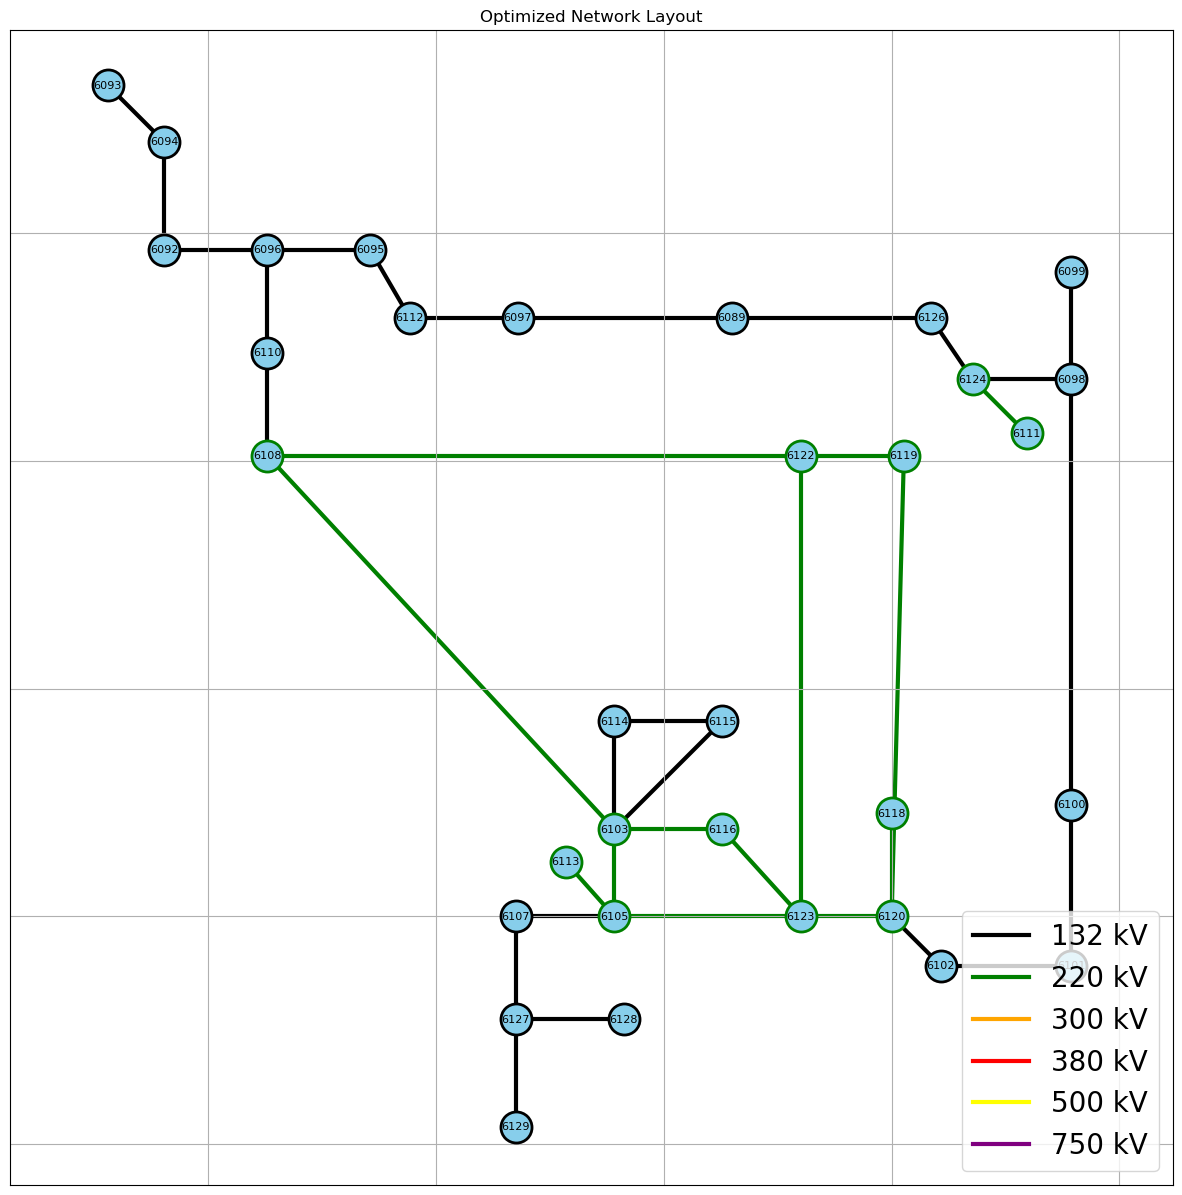

In [1370]:

# Update positions based on optimized x and y coordinates
updated_pos = {node: (value(model.x_pos[node]), value(model.y_pos[node])) for node in G.nodes()}




#draw_graph(G, updated_pos)

draw_graph(G, updated_pos, title="Optimized Network Layout")



In [1371]:
# Assuming 'G' is your graph and 'model' is your Pyomo model
# Updated positions based on optimized x and y coordinates
updated_pos = {node: (value(model.x_pos[node]), value(model.y_pos[node])) for node in G.nodes()}

# Initialize a list to store edge information along with the calculated angles
opt_edges_info = []

# Iterate through each edge in your graph
for edge in G.edges():
    node1, node2 = edge

    # Retrieve the updated positions for source and destination nodes
    new_src_x, new_src_y = updated_pos[node1]
    new_dst_x, new_dst_y = updated_pos[node2]

    # Calculate the angle using the updated positions
    angle = calculate_angle(new_src_x, new_src_y, new_dst_x, new_dst_y)

    formatted_angle = round(angle, 2)

    # Append the edge information and formatted angle to the list
    opt_edges_info.append({
        'Edge': edge,
        'Source': node1,
        'Destination': node2,
        'Angle (degrees)': formatted_angle  # Use the formatted angle
    })

# Convert the list of dictionaries to a pandas DataFrame for easy tabular display
opt_edges_info_df = pd.DataFrame(opt_edges_info)

# Print the DataFrame
#print(edges_info_df)
display(opt_edges_info_df)

,Edge,Source,Destination,Angle (degrees)
0,"(6093, 6094)",6093,6094,315.00
1,"(6107, 6127)",6107,6127,270.00
2,"(6127, 6128)",6127,6128,0.00
3,"(6127, 6129)",6127,6129,270.00
4,"(6089, 6126)",6089,6126,0.00
5,"(6089, 6097)",6089,6097,180.00
6,"(6124, 6126)",6124,6126,124.11
7,"(6098, 6124)",6098,6124,180.00
8,"(6098, 6100)",6098,6100,270.00
9,"(6098, 6099)",6098,6099,90.00


## Functions - Results

In [1372]:
def count_octilinearity_violations(opt_edges_info):
    violations = 0
    for edge_info in opt_edges_info:
        edge = edge_info['Edge']
        angle = edge_info['Angle (degrees)']
        # Check if the angle is not an exact multiple of 45 (including 0)
        if angle % 45 != 0:
            print(f"Violation found: {edge} with angle {angle}°")
            violations += 1
            
    if violations == 0:
        print("No violations found.")
    else:
        print(f"Total Octilinear Violations: {violations}")
        
    return violations



octilinearity_violations = count_octilinearity_violations(opt_edges_info)



Violation found: (6124, 6126) with angle 124.11°
Violation found: (6103, 6108) with angle 132.87°
Violation found: (6116, 6123) with angle 312.22°
Violation found: (6095, 6112) with angle 300.16°
Violation found: (6105, 6113) with angle 131.67°
Violation found: (6119, 6120) with angle 268.47°
Total Octilinear Violations: 6


## Debugging

In [1373]:
""" # Print initial positions
print("Initial Positions:")
#for node in model.Nodes:
print(f"Node {6193}: x = {model.x_init[6193]}, y = {model.y_init[6193]}")
print(f"Node {6398}: x = {model.x_init[6398]}, y = {model.y_init[6398]}\n\n")

# After solving the model

# Print final positions
print("\nFinal Positions:")
#for node in model.Nodes:
print(f"Node {6193}: x = {value(model.x_pos[6193])}, y = {value(model.y_pos[6193])}")
print(f"Node {6398}: x = {value(model.x_pos[6398])}, y = {value(model.y_pos[6398])}") """

' # Print initial positions\nprint("Initial Positions:")\n#for node in model.Nodes:\nprint(f"Node {6193}: x = {model.x_init[6193]}, y = {model.y_init[6193]}")\nprint(f"Node {6398}: x = {model.x_init[6398]}, y = {model.y_init[6398]}\n\n")\n\n# After solving the model\n\n# Print final positions\nprint("\nFinal Positions:")\n#for node in model.Nodes:\nprint(f"Node {6193}: x = {value(model.x_pos[6193])}, y = {value(model.y_pos[6193])}")\nprint(f"Node {6398}: x = {value(model.x_pos[6398])}, y = {value(model.y_pos[6398])}") '

In [1374]:

def get_sorted_neighbours(G, node, pos, initial_neighbour):
    angles_neighbours = []
    src_x, src_y = pos[node]

    # Convert G to an undirected graph to consider all adjacent nodes
    G_undirected = G.to_undirected()

    # Calculate angles and sort neighbours
    for neighbour in G_undirected.neighbors(node):
        dst_x, dst_y = pos[neighbour]
        angle = calculate_angle(src_x, src_y, dst_x, dst_y)
        angles_neighbours.append((angle, neighbour))

    angles_neighbours.sort()
    sorted_neighbours = [neighbour for _, neighbour in angles_neighbours]

    # Start the sorted list with the initial neighbour
    if initial_neighbour in sorted_neighbours:
        start_index = sorted_neighbours.index(initial_neighbour)
        sorted_neighbours = sorted_neighbours[start_index:] + sorted_neighbours[:start_index]

    return sorted_neighbours

def check_order_and_sector_violations(G, updated_pos, ordered_neighbours_dict):
    violations_count = 0
    
    for node, initial_neighbours in ordered_neighbours_dict.items():
        if initial_neighbours:  # Make sure there is at least one neighbour
            initial_first_neighbour = initial_neighbours[0]
            optimized_neighbours = get_sorted_neighbours(G, node, updated_pos, initial_first_neighbour)
            
            # Check for order violations
            if initial_neighbours != optimized_neighbours:
                print(f"Order violation at node {node}. Initial order: {initial_neighbours}, Optimized order: {optimized_neighbours}")
                violations_count += 1
            
            # Check for sector violations
            angles = [round(calculate_angle(updated_pos[node][0], updated_pos[node][1],
                                            updated_pos[neighbour][0], updated_pos[neighbour][1]), 1)
                      for neighbour in optimized_neighbours]
            sectors = [int(angle // 45) for angle in angles]
            for i in range(len(sectors) - 1):
                if sectors[i] == sectors[i + 1] and angles[i] != angles[i + 1]:
                    print(f"Sector violation between nodes {optimized_neighbours[i]} and {optimized_neighbours[i + 1]} "
                          f"at node {node} in sector {sectors[i]}. Rounded angles: {angles[i]}, {angles[i + 1]}")
                    violations_count += 1
                    break  # Stop at the first violation for this node

    if violations_count == 0:
        print("No circular order violations found.")
    else:
        print(f"Total circular order violations: {violations_count}")
    
    return violations_count

# Example usage
circular_order_violations = check_order_and_sector_violations(G, updated_pos, ordered_neighbours_dict)


Order violation at node 6120. Initial order: [6102, 6118, 6119, 6123], Optimized order: [6102, 6119, 6118, 6123]
Sector violation between nodes 6114 and 6108 at node 6103 in sector 2. Rounded angles: 90.0, 132.9
Sector violation between nodes 6103 and 6113 at node 6105 in sector 2. Rounded angles: 90.0, 131.7
Sector violation between nodes 6122 and 6116 at node 6123 in sector 2. Rounded angles: 90.0, 132.2
Total circular order violations: 4


In [1375]:

def check_edge_spacing_violations(specified_edge_pairs, pos):
    intersecting_edge_pairs = []
    violations_count = 0

    for edge1, edge2 in specified_edge_pairs:
        # Get the positions for the source and target nodes of each edge from the 'pos' argument
        src_pos1, tgt_pos1 = pos[edge1[0]], pos[edge1[1]]
        src_pos2, tgt_pos2 = pos[edge2[0]], pos[edge2[1]]
        
        # Create LineString objects for each edge
        line1 = LineString([src_pos1, tgt_pos1])
        line2 = LineString([src_pos2, tgt_pos2])

        # Check if the two edges intersect and are not merely touching at endpoints
        if line1.intersects(line2) and not line1.touches(line2):
            print(f"Violation found between edge {edge1} and edge {edge2}")
            intersecting_edge_pairs.append((edge1, edge2))
            violations_count += 1

    if violations_count == 0:
        print("No edge spacing violations found.")
    else:
        print(f"Total edge spacing violations: {violations_count}")

    return violations_count


edge_cross_violations = check_edge_spacing_violations(non_intersecting_non_incident_edges, updated_pos)


No edge spacing violations found.


In [1376]:

def display_results(stats, octilinearity_violations, circular_order_violations, edge_crossing_violations):
    # Construct the results DataFrame with the specified metrics
    results_df = pd.DataFrame([
        ['Solver Status', stats.get('Solver Status', 'N/A')],
        ['Objective Function Value', stats.get('Objective Value', 'N/A')],
        ['Computation Time (s)', stats.get('Solve Time (s)', 'N/A')],
        
        ['Number of Constraints', stats.get('Number of Constraints', 'N/A')],
        ['Number of Variables', stats.get('Number of Variables', 'N/A')],
        
        ['Total Number of Nodes', stats.get('Total Number of Nodes', 'N/A')],
        ['Total Number of Edges', stats.get('Total Number of Edges', 'N/A')],
        
        ['Octilinearity Violations', octilinearity_violations],
        ['Circular Order Violations', circular_order_violations],
        ['Edge Crossing Violations', edge_crossing_violations]
    ], columns=['Metric', 'Value'])
    
    # Display the DataFrame
    # If using a Jupyter Notebook, 'display()' will work directly.
    # In other environments, you might need to print the DataFrame or use another method to visualize it.
    display(results_df)



In [1377]:

stats = extract_solver_stats(results, country_df)


display_results(stats, octilinearity_violations, circular_order_violations, edge_cross_violations)


,Metric,Value
0,Solver Status,ok
1,Objective Function Value,1700
2,Computation Time (s),10.936096
3,Number of Constraints,20733
4,Number of Variables,5261
5,Total Number of Nodes,33
6,Total Number of Edges,39
7,Octilinearity Violations,6
8,Circular Order Violations,4
9,Edge Crossing Violations,0


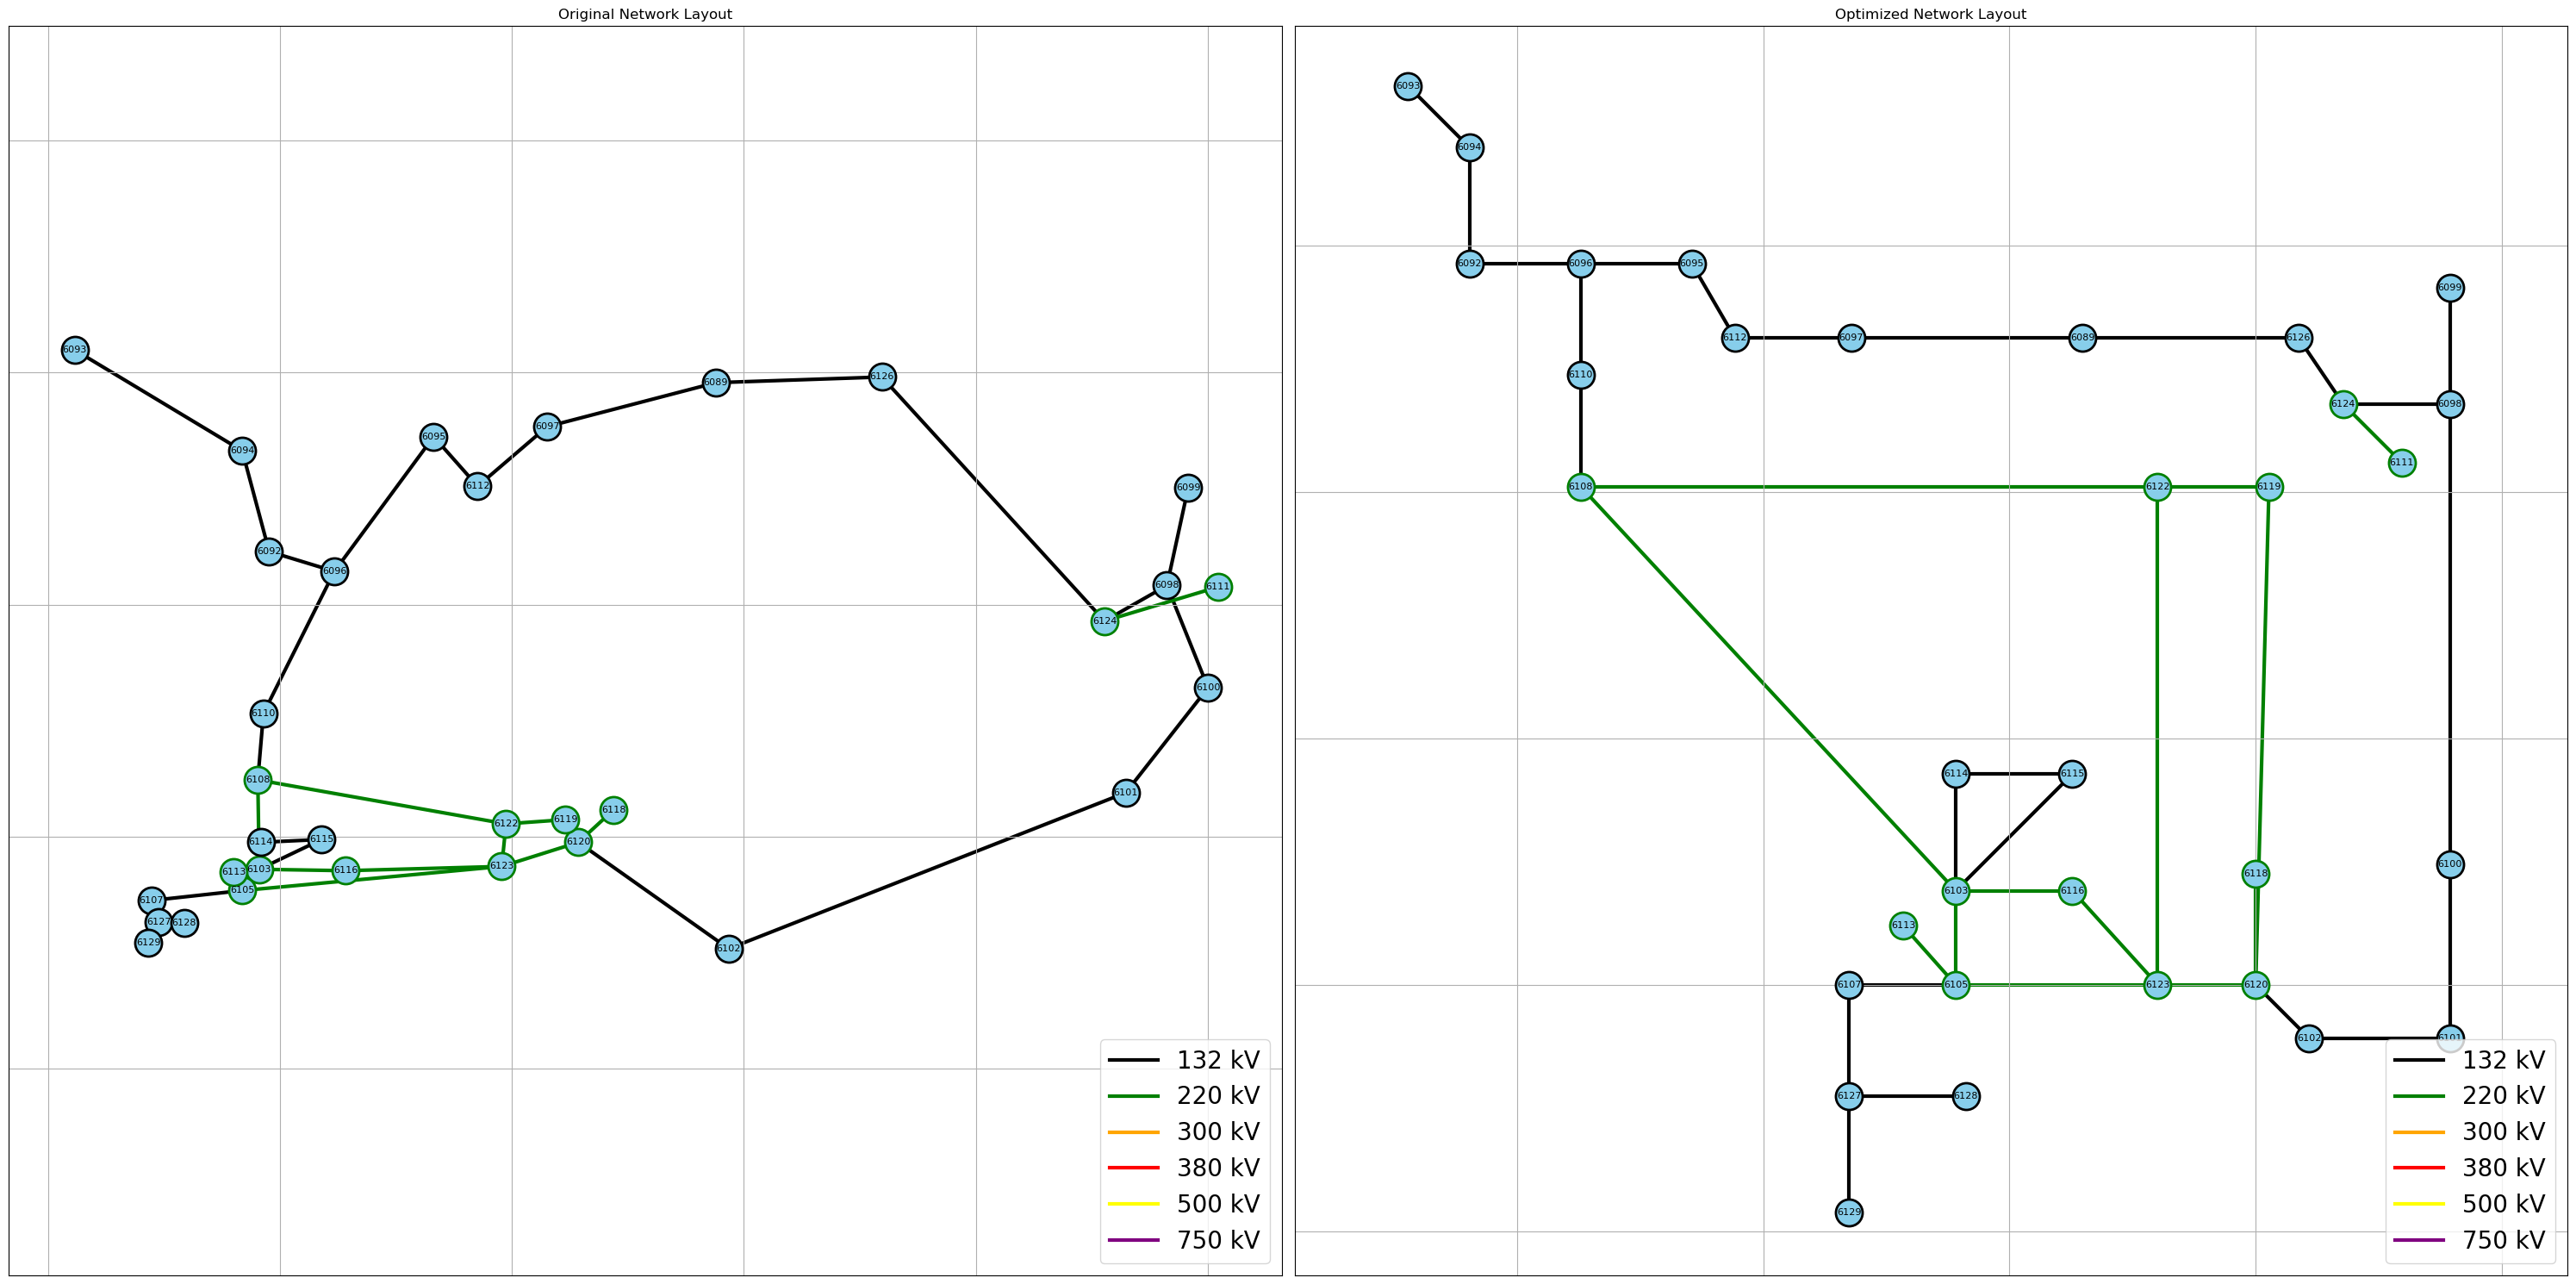

In [1378]:
# Now create a subplot with both the original and optimized graphs side by side
fig, axs = plt.subplots(1, 2, figsize=(30, 15))  # 1 row, 2 columns for the subplots

# Draw the original graph on the first subplot
draw_graph(G, pos, ax=axs[0], title="Original Network Layout")

# Draw the optimized graph on the second subplot
draw_graph(G, updated_pos, ax=axs[1], title="Optimized Network Layout")

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the combined plot
plt.show()